## Deconvolving single-cell family size distribution into chimeric and real components

In [7]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from sc_fingerprint import SingleCellFingerprint, SingleCellFingerprintDataStore
from sc_fsd_mixture_model import GeneralNegativeBinomialMixtureFamilySizeDistributionCodec, \
    SingleCellFamilySizeModel, DownsamplingRegularizedELBOLoss, get_expression_map

import pyro
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam
from pyro_extras import checkpoint_model, load_latest_checkpoint
from pyro_extras import ZeroInflatedNegativeBinomial

import torch

import scipy.sparse as sp
import logging
from collections import Counter
import pickle 
from scipy.signal import savgol_filter

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [8]:
dataset_name = 'pbmc4k_ss_rate_0.25'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'

# dataset_name = 'pbmc4k'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'

zinb_fitter_kwargs = {
    'lr': 0.5,
    'max_iters': 10_000,
    'p_zero_l1_reg': 0.001,
    'outlier_stringency': 5.0,
    'max_zinb_p_zero': 0.9995,
    'min_zinb_p_zero': 0.0005,
    'min_nb_phi': 0.01,
    'max_nb_phi': 0.95
}


# # generate a gene expression ladder for testing the full dynamic range
# all_genes_default_filter = np.load(
#     '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
# gene_expr_ladder_idx_list = all_genes_default_filter[::100]

# # Instantiate the fingerprint datastore
# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint,
#     gene_idx_list=gene_expr_ladder_idx_list,
#     n_gene_groups=10,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)


# load fingerprint and instantiate the data-store
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint = sc_fingerprint.filter_genes()

# Instantiate the fingerprint datastore
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint,
    top_k_genes=sc_fingerprint.num_genes,
    n_gene_groups=100,
    zinb_fitter_kwargs=zinb_fitter_kwargs,
    max_estimated_chimera_family_size=0)


# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint, top_k_genes=50, n_gene_groups=10, zinb_fitter_kwargs=zinb_fitter_kwargs)

# # generate top 200 genes
# all_genes_default_filter = np.load(
#     '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
# gene_expr_top_200_idx_list = all_genes_default_filter[:200]

# # Instantiate the fingerprint datastore
# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint,
#     gene_idx_list=gene_expr_top_200_idx_list,
#     n_gene_groups=10,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)

Number of genes failed the maximum Good-Turing criterion: 16672
Number of genes failed the minimum expression criterion: 20576
Number of genes failed both criteria: 16528
Number of retained genes: 12974


## Model, training, and regularization configuration

In [80]:
n_iters = 58_000

mb_genes_per_gene_group = 2
mb_expressing_cells_per_gene = 15
mb_silent_cells_per_gene = 1

training_e_lo_sum_width = 10
training_e_hi_sum_width = 10

training_e_lo_log_prob_prefactor = 1.0
training_e_hi_log_prob_prefactor = 1.0
training_e_obs_log_prob_prefactor = 1.0
training_fingerprint_obs_log_prob_prefactor = 1.0

disable_downsampling_regularization = True
downsampling_regularization_strength = 1.0
min_downsampling_rate = 0.5
max_downsampling_rate = 1.0
mb_genes_per_gene_group_reg = 1
mb_expressing_cells_per_gene_reg = 2
mb_silent_cells_per_gene_reg = 1



init_params_dict = {
    'chimera.alpha_c': 0.0,
    'chimera.beta_c': 0.5,
    'expr.phi_e_lo': 0.2,
    'fsd.gmm_num_components': 5,
    'fsd.gmm_dirichlet_concentration': 1.0,
    'fsd.gmm_min_weight_per_component': 1e-3,
    'fsd.gmm_init_xi_scale': 1.5,
    'fsd.gmm_min_xi_scale': 1.0,
    'fsd.gmm_init_components_perplexity': 0.5,
    'fsd.enable_fsd_w_dirichlet_reg': True,
    'fsd.enable_gmm_scale_optimization': True,
    'fsd.w_lo_dirichlet_reg_strength': 1.0,
    'fsd.w_hi_dirichlet_reg_strength': 1.0,
    'fsd.w_lo_dirichlet_concentration': 0.001,
    'fsd.w_hi_dirichlet_concentration': 0.001,
    'fsd.xi_posterior_min_scale': 0.0,
    'chimera.enable_hyperparameter_optimization': False}


fsd_init_params_dict = {
    'fsd_init.min_mu_lo': 0.02,
    'fsd_init.min_mu_hi': 0.2,
    'fsd_init.max_phi_lo': 1.5,
    'fsd_init.max_phi_hi': 0.5,
    'fsd_init.mu_decay': 0.75,
    'fsd_init.w_decay': 0.2,
    'fsd_init.mu_lo_to_mu_hi_ratio': 0.05}



model_constraint_params_dict = {
    # phi_lo is softly pinned to 1.0 (to decrease the parameter complexity of chimeras)
    'phi_lo_comps': {
        'pin_value': 1.0,
        'pin_strength': 1e8,
        'pin_exponent': 2},
    
    # no component of p_hi is allowed to be too over-dispersed
    'phi_hi_comps': {
        'upper_bound_value': 0.5,
        'upper_bound_width': 0.1,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # no component of p_lo can have too small or too large of a mean family size compared to the empirical mean
    'mu_lo_comps_to_mu_empirical_ratio': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 0.1,
        'upper_bound_width': 0.01,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
    
    # no component of p_hi can have too small or too large of a mean family size compared to the empirical mean
    'mu_hi_comps_to_mu_empirical_ratio': {
        'lower_bound_value': 0.3,
        'lower_bound_width': 0.1,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
    
    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'p_obs_lo_to_p_obs_hi_ratio': {
        'upper_bound_value': 0.2,
        'upper_bound_width': 0.05,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_hi_comps': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.005,
        'lower_bound_strength': 1e6,
        'lower_bound_exponent': 1},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_lo_comps': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.005,
        'lower_bound_strength': 1e6,
        'lower_bound_exponent': 1},

    # make sure that phi_e_hi is not too small or too large (to prevent over/under-flows)
    'phi_e_hi_batch': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # make sure that logit_p_zero_e_hi_batch is not too small or too large (to prevent over/under-flows)
    'logit_p_zero_e_hi_batch': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
}


def adam_args(module_name, param_name):
    slow_lr = 2e-3
    slow_params = {
        'alpha_c', 'beta_c',
        'mu_e_lo', 'phi_e_lo',
        'mu_e_hi', 'phi_e_hi', 'logit_p_zero_e_hi',
        'fsd_xi_prior_weights_map'}
    
    fast_lr = 5e-3
    fast_params = {}
    
    default_lr = 5e-3
    
    if param_name in slow_params:
        lr = slow_lr
    elif param_name in fast_params:
        lr = fast_lr
    else:
        lr = default_lr
    
    return {"lr": lr, "eps": 1e-4, 'betas': (0.95, 0.999)}

In [61]:
root = '/home/jupyter/data/10x/out'
# suffix = "expr_small_ladder_test__poisson_proper"
suffix = "default_gene_filters__rc_poisson_proper"
# suffix = "top_200_genes__poisson_e_obs__zinb_heavy_reg_gmm__new"
# suffix = "top_50_genes__zinb_heavy_reg_gmm"

if init_params_dict['chimera.enable_hyperparameter_optimization']:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_variable_chimera_hyperparameters_" +
        f"_{suffix}")
else:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_alpha_{init_params_dict['chimera.alpha_c']:.1f}_" +
        f"_beta_{init_params_dict['chimera.beta_c']:.1f}_" +
        f"_{suffix}")

checkpoint_path = os.path.join(output_path, "checkpoints")

try:
    print(output_path)
    print(checkpoint_path)
    os.mkdir(output_path)
    os.mkdir(checkpoint_path)
except:
    pass

e_lo_map_output_path = os.path.join(output_path, "e_lo_map.npy")
e_lo_mean_output_path = os.path.join(output_path, "e_lo_mean.npy")
e_lo_var_output_path = os.path.join(output_path, "e_lo_var.npy")
e_lo_ci_lower_output_path = os.path.join(output_path, "e_lo_ci_lower.npy")
e_lo_ci_upper_output_path = os.path.join(output_path, "e_lo_ci_upper.npy")

e_hi_map_output_path = os.path.join(output_path, "e_hi_map.npy")
e_hi_mean_output_path = os.path.join(output_path, "e_hi_mean.npy")
e_hi_var_output_path = os.path.join(output_path, "e_hi_var.npy")
e_hi_ci_lower_output_path = os.path.join(output_path, "e_hi_ci_lower.npy")
e_hi_ci_upper_output_path = os.path.join(output_path, "e_hi_ci_upper.npy")

gene_indices_output_path = os.path.join(output_path, "gene_indices.npy")
cell_barcodes_output_path = os.path.join(output_path, "cell_barcodes.npy")

/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.25__alpha_0.0__beta_0.5__default_gene_filters__rc_poisson_proper
/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.25__alpha_0.0__beta_0.5__default_gene_filters__rc_poisson_proper/checkpoints


## Training schedule, optimizer, loss, and regularization

In [62]:
pyro.clear_param_store()

device = torch.device('cuda')
dtype = torch.float

fsd_codec = GeneralNegativeBinomialMixtureFamilySizeDistributionCodec(
    sc_fingerprint_datastore=sc_fingerprint_datastore,
    n_fsd_lo_comps=1,
    n_fsd_hi_comps=2,
    fsd_init_params_dict=fsd_init_params_dict)

model = SingleCellFamilySizeModel(
    init_params_dict=init_params_dict,
    model_constraint_params_dict=model_constraint_params_dict,
    sc_fingerprint_datastore=sc_fingerprint_datastore,
    fsd_codec=fsd_codec,
    e_lo_prior_dist='poisson',
    e_hi_prior_dist='zinb',
    model_type='poisson',# 'approx_multinomial',
    guide_type='map')

optim = Adam(adam_args)

custom_loss = DownsamplingRegularizedELBOLoss(
    downsampling_regularization_strength=downsampling_regularization_strength,
    min_downsampling_rate=min_downsampling_rate,
    max_downsampling_rate=max_downsampling_rate,
    disable_downsampling_regularization=disable_downsampling_regularization,
    keep_history=True)

svi = SVI(model.model, model.guide, optim, loss=custom_loss.differentiable_loss)

100%|██████████| 12974/12974 [00:30<00:00, 427.83it/s]


In [63]:
# mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(1, 10, 15)
# trace = poutine.trace(model.model).get_trace(mb_data)
# print(trace.format_shapes())

In [64]:
loss_hist = []
custom_loss.reset_history()
# load_latest_checkpoint(checkpoint_path)

# other_output_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__default_gene_filters__rc'
# if other_output_path is None:
#     model_output_path = os.path.join(output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
# else:
#     model_output_path = os.path.join(other_output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
# pyro.get_param_store().load(model_output_path)

# with torch.no_grad():
#     # adapt model parameters to downsampled dataset
#     fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))

#     kappa = 0.25
#     downsampled_fsd_params_dict = dict()
#     downsampled_fsd_params_dict['phi_lo'] = fsd_params_dict['phi_lo']
#     downsampled_fsd_params_dict['phi_hi'] = fsd_params_dict['phi_hi']
#     downsampled_fsd_params_dict['w_lo'] = fsd_params_dict['w_lo']
#     downsampled_fsd_params_dict['w_hi'] = fsd_params_dict['w_hi']
#     downsampled_fsd_params_dict['mu_lo'] = kappa * fsd_params_dict['mu_lo']
#     downsampled_fsd_params_dict['mu_hi'] = kappa * fsd_params_dict['mu_hi']
#     downsampled_fsd_xi_posterior_loc = fsd_codec.encode(downsampled_fsd_params_dict)
    
# pyro.get_param_store()['fsd_xi_posterior_loc'].data.copy_(downsampled_fsd_xi_posterior_loc.data)

In [65]:
# # reset e_hi parameters to the initial estimate
# from pyro_extras import logit
# with torch.no_grad():
#     pyro.get_param_store()._params['mu_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_mu_e_hi).log())
#     pyro.get_param_store()._params['phi_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_phi_e_hi).log())
#     pyro.get_param_store()._params['logit_p_zero_e_hi'].data.copy_(logit(torch.tensor(sc_fingerprint_datastore.estimated_p_zero_e_hi)))

In [66]:
# pyro.get_param_store()._params['beta_c'].data.copy_(torch.tensor(1.).log())

In [81]:
print_loss_frequency = 50
checkpoint_frequency = 1_000

mb_loss_list = []
fsd_abs_res_list = []
loss_scale_factor = 1. / (sc_fingerprint_datastore.n_cells * sc_fingerprint_datastore.n_genes)
prev_fsd_xi_posterior_loc = torch.zeros(
    (sc_fingerprint_datastore.n_genes, fsd_codec.total_fsd_params),
    dtype=dtype, device=device)

t0 = time.time()
for i_iter in range(n_iters):
    # generate minibatch for elbo loss
    mb_data_elbo = sc_fingerprint_datastore.generate_stratified_sample_torch(
        mb_genes_per_gene_group,
        mb_expressing_cells_per_gene,
        mb_silent_cells_per_gene)
    mb_data_elbo['e_lo_sum_width'] = training_e_lo_sum_width
    mb_data_elbo['e_hi_sum_width'] = training_e_hi_sum_width    
    mb_data_elbo['e_obs_log_prob_prefactor'] = training_e_obs_log_prob_prefactor

    # generate minibatch for downsampling regularization
    if not disable_downsampling_regularization:
        mb_data_reg = sc_fingerprint_datastore.generate_stratified_sample_torch(
            mb_genes_per_gene_group_reg,
            mb_expressing_cells_per_gene_reg,
            mb_silent_cells_per_gene_reg)
        mb_data_reg['e_lo_sum_width'] = training_e_lo_sum_width
        mb_data_reg['e_hi_sum_width'] = training_e_hi_sum_width
        mb_data_reg['e_obs_log_prob_prefactor'] = training_e_obs_log_prob_prefactor
    else:
        mb_data_reg = None
    
    # SVI update
    mb_loss = svi.step(mb_data_elbo, mb_data_reg)
        
    # bookkeeping, history tracking, etc.
    mb_loss_per_cell_gene = loss_scale_factor * mb_loss
    mb_loss_list.append(mb_loss_per_cell_gene)
    
    # calculate change in fsd parameters
    new_fsd_xi_posterior_loc = pyro.param("fsd_xi_posterior_loc").clone().detach()
    xi_posterior_abs_res_mean = torch.mean((new_fsd_xi_posterior_loc - prev_fsd_xi_posterior_loc).abs()).item()
    prev_fsd_xi_posterior_loc = new_fsd_xi_posterior_loc    
    fsd_abs_res_list.append(1_000 * xi_posterior_abs_res_mean)
    
    if i_iter % print_loss_frequency == 0:
        t1 = time.time()
        
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        fsd_abs_res_mean, fsd_abs_res_std = np.mean(fsd_abs_res_list), np.std(fsd_abs_res_list)
        phi_e_lo_mean, phi_e_lo_std = torch.mean(pyro.param("phi_e_lo")).item(), torch.std(pyro.param("phi_e_lo")).item()
        phi_e_lo_max, phi_e_lo_min = torch.max(pyro.param("phi_e_lo")).item(), torch.min(pyro.param("phi_e_lo")).item()
        phi_e_hi_mean, phi_e_hi_std = torch.mean(pyro.param("phi_e_hi")).item(), torch.std(pyro.param("phi_e_hi")).item()
        phi_e_hi_max, phi_e_hi_min = torch.max(pyro.param("phi_e_hi")).item(), torch.min(pyro.param("phi_e_hi")).item()
        logit_p_zero_e_hi_mean, logit_p_zero_e_hi_std = (
            torch.mean(pyro.param("logit_p_zero_e_hi")).item(),
            torch.std(pyro.param("logit_p_zero_e_hi")).item())
        logit_p_zero_e_hi_max, logit_p_zero_e_hi_min = (
            torch.max(pyro.param("logit_p_zero_e_hi")).item(),
            torch.min(pyro.param("logit_p_zero_e_hi")).item())

        mb_loss_list = []
        fsd_abs_res_list = []
        print(f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, ' +
              f'fsd_abs_res: {fsd_abs_res_mean:.4f} +- {fsd_abs_res_std:.4f}, ' +
              f'time: {(t1 - t0):.3f}s')
        print(f'alpha_c: {pyro.param("alpha_c").item():.3f}')
        print(f'beta_c: {pyro.param("beta_c").item():.3f}')
        print(f'phi_e_lo: {phi_e_lo_mean:.4f} +- {phi_e_lo_std:.3f} [{phi_e_lo_min:.4f}, {phi_e_lo_max:.4f}]')
        print(f'phi_e_hi: {phi_e_hi_mean:.4f} +- {phi_e_hi_std:.3f} [{phi_e_hi_min:.4f}, {phi_e_hi_max:.4f}]')
        print(f'logit_p_zero_e_hi: {logit_p_zero_e_hi_mean:.4f} +- ' \
              + f'{logit_p_zero_e_hi_std:.4f} [{logit_p_zero_e_hi_min:.4f}, {logit_p_zero_e_hi_max:.4f}]')
        t0 = t1
        # print(f'mu_lo_global: {pyro.param("fsd_codec$$$log_mu_lo_global").exp().item():.3f}')
        # print(f'phi_lo_global: {fsd_codec.log_phi_lo_global.exp().item():.3f}')
    loss_hist.append(mb_loss_per_cell_gene)

    if i_iter % checkpoint_frequency == 0:
        logging.warning("Checkpointing the latest model parameters...")
        checkpoint_model(checkpoint_path)

Iteration number: 0, loss: 11.050 +- 0.000, fsd_abs_res: 1412.0675 +- 0.0000, time: 0.139s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0299 +- 0.214 [0.0019, 3.9303]
logit_p_zero_e_hi: 0.4463 +- 2.8457 [-7.0079, 6.9628]
Iteration number: 50, loss: 8.170 +- 1.754, fsd_abs_res: 0.2068 +- 0.0031, time: 5.591s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0299 +- 0.214 [0.0020, 3.9102]
logit_p_zero_e_hi: 0.4457 +- 2.8459 [-7.0168, 6.9628]
Iteration number: 100, loss: 7.626 +- 1.879, fsd_abs_res: 0.2062 +- 0.0007, time: 5.488s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0299 +- 0.214 [0.0020, 3.9060]
logit_p_zero_e_hi: 0.4452 +- 2.8460 [-7.0082, 6.9628]
Iteration number: 150, loss: 7.785 +- 1.743, fsd_abs_res: 0.2039 +- 0.0011, time: 5.471s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0300 +- 0.214 [0.0020, 3.9096]
logit_p_zero_e_hi: 0.

Iteration number: 1000, loss: 7.523 +- 1.893, fsd_abs_res: 0.2015 +- 0.0016, time: 5.421s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0304 +- 0.218 [0.0020, 3.9951]
logit_p_zero_e_hi: 0.4333 +- 2.8472 [-7.0083, 6.9909]
Iteration number: 1050, loss: 7.634 +- 1.747, fsd_abs_res: 0.2044 +- 0.0013, time: 5.607s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0305 +- 0.218 [0.0019, 3.9950]
logit_p_zero_e_hi: 0.4325 +- 2.8473 [-7.0108, 6.9909]
Iteration number: 1100, loss: 7.596 +- 1.637, fsd_abs_res: 0.2036 +- 0.0014, time: 5.670s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0305 +- 0.218 [0.0019, 3.9950]
logit_p_zero_e_hi: 0.4319 +- 2.8473 [-7.0069, 6.9978]
Iteration number: 1150, loss: 7.766 +- 1.961, fsd_abs_res: 0.2043 +- 0.0010, time: 5.442s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0306 +- 0.219 [0.0019, 4.0156]
logit_p_zero_e_hi:

Iteration number: 2000, loss: 7.941 +- 2.179, fsd_abs_res: 0.2040 +- 0.0014, time: 5.445s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0308 +- 0.220 [0.0019, 4.0865]
logit_p_zero_e_hi: 0.4201 +- 2.8484 [-7.0123, 6.9580]
Iteration number: 2050, loss: 7.898 +- 2.003, fsd_abs_res: 0.2037 +- 0.0012, time: 5.451s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0308 +- 0.220 [0.0019, 4.0893]
logit_p_zero_e_hi: 0.4193 +- 2.8485 [-7.0089, 6.9603]
Iteration number: 2100, loss: 8.214 +- 1.994, fsd_abs_res: 0.2032 +- 0.0008, time: 5.436s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0309 +- 0.221 [0.0019, 4.0895]
logit_p_zero_e_hi: 0.4187 +- 2.8485 [-7.0099, 6.9629]
Iteration number: 2150, loss: 7.973 +- 2.074, fsd_abs_res: 0.2052 +- 0.0008, time: 5.449s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0310 +- 0.221 [0.0019, 4.0267]
logit_p_zero_e_hi:

Iteration number: 3000, loss: 8.041 +- 1.830, fsd_abs_res: 0.2038 +- 0.0007, time: 5.430s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0315 +- 0.225 [0.0019, 4.0067]
logit_p_zero_e_hi: 0.4068 +- 2.8491 [-7.0059, 6.9913]
Iteration number: 3050, loss: 8.368 +- 1.871, fsd_abs_res: 0.2060 +- 0.0019, time: 5.417s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0316 +- 0.225 [0.0019, 4.0085]
logit_p_zero_e_hi: 0.4063 +- 2.8491 [-7.0051, 6.9913]
Iteration number: 3100, loss: 7.967 +- 2.165, fsd_abs_res: 0.2060 +- 0.0012, time: 5.416s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0316 +- 0.225 [0.0019, 4.0110]
logit_p_zero_e_hi: 0.4058 +- 2.8492 [-7.0031, 6.9929]
Iteration number: 3150, loss: 7.743 +- 1.720, fsd_abs_res: 0.2024 +- 0.0014, time: 5.448s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0316 +- 0.225 [0.0019, 4.0322]
logit_p_zero_e_hi:

Iteration number: 4000, loss: 8.047 +- 2.223, fsd_abs_res: 0.2057 +- 0.0012, time: 5.431s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0317 +- 0.224 [0.0019, 3.9155]
logit_p_zero_e_hi: 0.3941 +- 2.8496 [-7.0119, 6.9997]
Iteration number: 4050, loss: 7.963 +- 1.649, fsd_abs_res: 0.2059 +- 0.0013, time: 5.390s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0317 +- 0.224 [0.0019, 3.9155]
logit_p_zero_e_hi: 0.3935 +- 2.8496 [-7.0030, 6.9877]
Iteration number: 4100, loss: 7.842 +- 1.612, fsd_abs_res: 0.2060 +- 0.0009, time: 5.400s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0318 +- 0.224 [0.0019, 3.9155]
logit_p_zero_e_hi: 0.3929 +- 2.8497 [-7.0102, 6.9900]
Iteration number: 4150, loss: 7.665 +- 2.000, fsd_abs_res: 0.2051 +- 0.0008, time: 5.391s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0318 +- 0.224 [0.0019, 3.9155]
logit_p_zero_e_hi:

Iteration number: 5000, loss: 7.551 +- 2.007, fsd_abs_res: 0.2050 +- 0.0017, time: 5.463s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0322 +- 0.227 [0.0019, 3.9393]
logit_p_zero_e_hi: 0.3809 +- 2.8511 [-7.0037, 6.9743]
Iteration number: 5050, loss: 7.547 +- 2.204, fsd_abs_res: 0.2063 +- 0.0013, time: 5.454s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0323 +- 0.228 [0.0019, 3.9396]
logit_p_zero_e_hi: 0.3803 +- 2.8511 [-7.0101, 6.9716]
Iteration number: 5100, loss: 7.631 +- 1.852, fsd_abs_res: 0.2060 +- 0.0013, time: 5.434s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0323 +- 0.228 [0.0019, 3.9396]
logit_p_zero_e_hi: 0.3796 +- 2.8512 [-7.0080, 6.9702]
Iteration number: 5150, loss: 8.260 +- 1.495, fsd_abs_res: 0.2041 +- 0.0008, time: 5.422s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0323 +- 0.228 [0.0019, 3.9396]
logit_p_zero_e_hi:

Iteration number: 6000, loss: 7.470 +- 1.897, fsd_abs_res: 0.2051 +- 0.0012, time: 5.456s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0326 +- 0.229 [0.0019, 3.9235]
logit_p_zero_e_hi: 0.3687 +- 2.8518 [-7.0223, 6.9741]
Iteration number: 6050, loss: 8.318 +- 2.265, fsd_abs_res: 0.2056 +- 0.0013, time: 5.449s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0326 +- 0.229 [0.0019, 3.9327]
logit_p_zero_e_hi: 0.3679 +- 2.8518 [-7.0223, 6.9741]
Iteration number: 6100, loss: 7.900 +- 1.896, fsd_abs_res: 0.2035 +- 0.0007, time: 5.474s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0326 +- 0.229 [0.0020, 3.9216]
logit_p_zero_e_hi: 0.3671 +- 2.8517 [-7.0140, 6.9755]
Iteration number: 6150, loss: 7.461 +- 1.927, fsd_abs_res: 0.2053 +- 0.0010, time: 5.438s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0326 +- 0.229 [0.0020, 3.9310]
logit_p_zero_e_hi:

Iteration number: 7000, loss: 7.539 +- 1.788, fsd_abs_res: 0.2043 +- 0.0012, time: 5.432s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0330 +- 0.232 [0.0020, 3.9761]
logit_p_zero_e_hi: 0.3561 +- 2.8529 [-7.0073, 6.9898]
Iteration number: 7050, loss: 7.911 +- 1.933, fsd_abs_res: 0.2059 +- 0.0018, time: 5.435s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0330 +- 0.232 [0.0019, 3.9788]
logit_p_zero_e_hi: 0.3555 +- 2.8530 [-7.0101, 6.9906]
Iteration number: 7100, loss: 7.611 +- 1.909, fsd_abs_res: 0.2060 +- 0.0018, time: 5.529s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0331 +- 0.233 [0.0019, 3.9920]
logit_p_zero_e_hi: 0.3549 +- 2.8530 [-7.0081, 6.9943]
Iteration number: 7150, loss: 7.748 +- 2.178, fsd_abs_res: 0.2061 +- 0.0010, time: 5.560s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0331 +- 0.233 [0.0019, 4.0020]
logit_p_zero_e_hi:

Iteration number: 8000, loss: 7.532 +- 2.172, fsd_abs_res: 0.2057 +- 0.0010, time: 5.561s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0333 +- 0.233 [0.0020, 3.9989]
logit_p_zero_e_hi: 0.3434 +- 2.8541 [-7.0079, 6.9982]
Iteration number: 8050, loss: 8.430 +- 2.319, fsd_abs_res: 0.2084 +- 0.0011, time: 5.530s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0333 +- 0.233 [0.0019, 3.9989]
logit_p_zero_e_hi: 0.3427 +- 2.8542 [-7.0109, 7.0014]
Iteration number: 8100, loss: 7.860 +- 2.001, fsd_abs_res: 0.2076 +- 0.0015, time: 5.505s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0334 +- 0.234 [0.0019, 3.9989]
logit_p_zero_e_hi: 0.3421 +- 2.8542 [-7.0053, 7.0026]
Iteration number: 8150, loss: 7.880 +- 1.635, fsd_abs_res: 0.2067 +- 0.0016, time: 5.464s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0334 +- 0.234 [0.0019, 3.9989]
logit_p_zero_e_hi:

Iteration number: 9000, loss: 7.844 +- 1.848, fsd_abs_res: 0.2064 +- 0.0011, time: 5.495s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0337 +- 0.235 [0.0019, 4.0075]
logit_p_zero_e_hi: 0.3310 +- 2.8547 [-7.0157, 7.0155]
Iteration number: 9050, loss: 7.683 +- 1.799, fsd_abs_res: 0.2061 +- 0.0014, time: 5.510s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0337 +- 0.235 [0.0019, 4.0113]
logit_p_zero_e_hi: 0.3304 +- 2.8548 [-7.0034, 7.0246]
Iteration number: 9100, loss: 7.954 +- 1.858, fsd_abs_res: 0.2061 +- 0.0014, time: 5.514s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0337 +- 0.235 [0.0019, 3.9855]
logit_p_zero_e_hi: 0.3299 +- 2.8550 [-7.0053, 7.0253]
Iteration number: 9150, loss: 8.153 +- 1.633, fsd_abs_res: 0.2087 +- 0.0020, time: 5.469s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0337 +- 0.235 [0.0019, 4.0184]
logit_p_zero_e_hi:

Iteration number: 10000, loss: 7.933 +- 1.833, fsd_abs_res: 0.2074 +- 0.0009, time: 5.659s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0341 +- 0.237 [0.0019, 3.9938]
logit_p_zero_e_hi: 0.3191 +- 2.8560 [-7.0094, 7.0028]
Iteration number: 10050, loss: 7.686 +- 1.859, fsd_abs_res: 0.2075 +- 0.0011, time: 5.474s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0341 +- 0.237 [0.0019, 3.9971]
logit_p_zero_e_hi: 0.3185 +- 2.8560 [-7.0205, 7.0029]
Iteration number: 10100, loss: 7.854 +- 2.130, fsd_abs_res: 0.2075 +- 0.0013, time: 5.523s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0341 +- 0.237 [0.0019, 4.0165]
logit_p_zero_e_hi: 0.3179 +- 2.8559 [-7.0036, 7.0029]
Iteration number: 10150, loss: 7.630 +- 1.814, fsd_abs_res: 0.2099 +- 0.0017, time: 5.484s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0341 +- 0.237 [0.0020, 3.9874]
logit_p_zero_e

Iteration number: 11000, loss: 7.883 +- 1.864, fsd_abs_res: 0.2081 +- 0.0015, time: 5.422s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0343 +- 0.237 [0.0019, 3.9196]
logit_p_zero_e_hi: 0.3074 +- 2.8577 [-7.0106, 6.9753]
Iteration number: 11050, loss: 7.983 +- 1.712, fsd_abs_res: 0.2085 +- 0.0011, time: 5.487s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0343 +- 0.237 [0.0019, 3.9145]
logit_p_zero_e_hi: 0.3067 +- 2.8578 [-7.0149, 6.9749]
Iteration number: 11100, loss: 7.883 +- 1.849, fsd_abs_res: 0.2081 +- 0.0013, time: 5.472s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0343 +- 0.237 [0.0019, 3.9141]
logit_p_zero_e_hi: 0.3061 +- 2.8579 [-7.0248, 6.9748]
Iteration number: 11150, loss: 7.645 +- 1.788, fsd_abs_res: 0.2067 +- 0.0009, time: 5.501s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0343 +- 0.238 [0.0019, 3.9135]
logit_p_zero_e

Iteration number: 12000, loss: 7.973 +- 2.000, fsd_abs_res: 0.2069 +- 0.0012, time: 5.435s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0349 +- 0.242 [0.0019, 3.9679]
logit_p_zero_e_hi: 0.2959 +- 2.8593 [-7.0146, 6.9782]
Iteration number: 12050, loss: 7.873 +- 1.937, fsd_abs_res: 0.2089 +- 0.0009, time: 5.412s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0349 +- 0.241 [0.0019, 3.9709]
logit_p_zero_e_hi: 0.2952 +- 2.8593 [-7.0071, 6.9782]
Iteration number: 12100, loss: 7.504 +- 1.835, fsd_abs_res: 0.2074 +- 0.0013, time: 5.482s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0349 +- 0.241 [0.0019, 3.9847]
logit_p_zero_e_hi: 0.2945 +- 2.8594 [-7.0152, 6.9782]
Iteration number: 12150, loss: 8.034 +- 2.371, fsd_abs_res: 0.2070 +- 0.0015, time: 5.459s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0349 +- 0.242 [0.0019, 3.9630]
logit_p_zero_e

Iteration number: 13000, loss: 7.636 +- 1.802, fsd_abs_res: 0.2096 +- 0.0015, time: 5.443s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0352 +- 0.243 [0.0019, 3.9748]
logit_p_zero_e_hi: 0.2847 +- 2.8603 [-7.0122, 6.9852]
Iteration number: 13050, loss: 7.794 +- 2.044, fsd_abs_res: 0.2086 +- 0.0012, time: 5.434s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0352 +- 0.243 [0.0019, 3.9759]
logit_p_zero_e_hi: 0.2840 +- 2.8603 [-7.0062, 6.9858]
Iteration number: 13100, loss: 7.624 +- 1.801, fsd_abs_res: 0.2050 +- 0.0018, time: 5.448s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0352 +- 0.243 [0.0019, 3.9828]
logit_p_zero_e_hi: 0.2834 +- 2.8604 [-7.0105, 6.9929]
Iteration number: 13150, loss: 7.701 +- 1.654, fsd_abs_res: 0.2057 +- 0.0011, time: 5.499s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0352 +- 0.243 [0.0019, 3.9940]
logit_p_zero_e

Iteration number: 14000, loss: 7.559 +- 1.698, fsd_abs_res: 0.2101 +- 0.0011, time: 5.388s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0355 +- 0.244 [0.0019, 4.0242]
logit_p_zero_e_hi: 0.2728 +- 2.8618 [-7.0082, 7.0250]
Iteration number: 14050, loss: 7.678 +- 1.824, fsd_abs_res: 0.2086 +- 0.0011, time: 5.501s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0356 +- 0.244 [0.0019, 4.0243]
logit_p_zero_e_hi: 0.2723 +- 2.8619 [-7.0095, 7.0251]
Iteration number: 14100, loss: 7.751 +- 1.547, fsd_abs_res: 0.2093 +- 0.0016, time: 5.440s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0356 +- 0.245 [0.0019, 4.0048]
logit_p_zero_e_hi: 0.2718 +- 2.8620 [-7.0057, 6.9681]
Iteration number: 14150, loss: 7.893 +- 2.181, fsd_abs_res: 0.2070 +- 0.0011, time: 5.464s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0356 +- 0.244 [0.0019, 3.9311]
logit_p_zero_e

Iteration number: 15000, loss: 8.146 +- 2.112, fsd_abs_res: 0.2092 +- 0.0008, time: 5.430s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0359 +- 0.247 [0.0019, 4.0326]
logit_p_zero_e_hi: 0.2622 +- 2.8632 [-7.0112, 6.9635]
Iteration number: 15050, loss: 7.906 +- 2.024, fsd_abs_res: 0.2084 +- 0.0013, time: 5.417s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0360 +- 0.248 [0.0019, 4.0328]
logit_p_zero_e_hi: 0.2616 +- 2.8632 [-7.0080, 6.9634]
Iteration number: 15100, loss: 7.832 +- 1.860, fsd_abs_res: 0.2087 +- 0.0021, time: 5.430s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0360 +- 0.247 [0.0019, 4.0328]
logit_p_zero_e_hi: 0.2609 +- 2.8631 [-7.0105, 6.9642]
Iteration number: 15150, loss: 7.432 +- 1.571, fsd_abs_res: 0.2065 +- 0.0018, time: 5.426s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0360 +- 0.248 [0.0019, 4.0328]
logit_p_zero_e

Iteration number: 16000, loss: 8.114 +- 1.978, fsd_abs_res: 0.2086 +- 0.0007, time: 5.415s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0363 +- 0.249 [0.0019, 3.9552]
logit_p_zero_e_hi: 0.2504 +- 2.8645 [-7.0078, 6.9758]
Iteration number: 16050, loss: 7.874 +- 1.780, fsd_abs_res: 0.2097 +- 0.0009, time: 5.482s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0363 +- 0.250 [0.0020, 3.9684]
logit_p_zero_e_hi: 0.2499 +- 2.8646 [-7.0086, 6.9777]
Iteration number: 16100, loss: 7.287 +- 1.878, fsd_abs_res: 0.2086 +- 0.0010, time: 5.634s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0363 +- 0.250 [0.0020, 3.9705]
logit_p_zero_e_hi: 0.2493 +- 2.8646 [-7.0090, 6.9778]
Iteration number: 16150, loss: 7.453 +- 1.927, fsd_abs_res: 0.2072 +- 0.0013, time: 5.427s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0364 +- 0.250 [0.0020, 3.9827]
logit_p_zero_e

Iteration number: 17000, loss: 7.796 +- 1.811, fsd_abs_res: 0.2103 +- 0.0008, time: 5.459s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0367 +- 0.252 [0.0019, 3.9456]
logit_p_zero_e_hi: 0.2394 +- 2.8667 [-7.0078, 6.9688]
Iteration number: 17050, loss: 8.179 +- 1.966, fsd_abs_res: 0.2098 +- 0.0011, time: 5.424s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0368 +- 0.252 [0.0019, 3.9441]
logit_p_zero_e_hi: 0.2389 +- 2.8667 [-7.0077, 6.9688]
Iteration number: 17100, loss: 7.410 +- 1.822, fsd_abs_res: 0.2080 +- 0.0023, time: 5.416s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0368 +- 0.253 [0.0019, 4.0055]
logit_p_zero_e_hi: 0.2383 +- 2.8667 [-7.0123, 6.9696]
Iteration number: 17150, loss: 7.790 +- 1.736, fsd_abs_res: 0.2086 +- 0.0020, time: 5.447s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0368 +- 0.253 [0.0019, 3.9874]
logit_p_zero_e

Iteration number: 18000, loss: 7.561 +- 1.920, fsd_abs_res: 0.2084 +- 0.0011, time: 5.410s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0370 +- 0.252 [0.0020, 4.0027]
logit_p_zero_e_hi: 0.2289 +- 2.8678 [-7.0072, 7.0009]
Iteration number: 18050, loss: 7.538 +- 1.683, fsd_abs_res: 0.2071 +- 0.0014, time: 5.411s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0370 +- 0.252 [0.0020, 4.0040]
logit_p_zero_e_hi: 0.2283 +- 2.8678 [-7.0074, 7.0027]
Iteration number: 18100, loss: 8.142 +- 1.704, fsd_abs_res: 0.2080 +- 0.0014, time: 5.418s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0370 +- 0.252 [0.0019, 4.0041]
logit_p_zero_e_hi: 0.2278 +- 2.8678 [-7.0106, 6.9942]
Iteration number: 18150, loss: 7.845 +- 1.833, fsd_abs_res: 0.2076 +- 0.0011, time: 5.427s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0370 +- 0.252 [0.0019, 3.9768]
logit_p_zero_e

Iteration number: 19000, loss: 8.015 +- 1.920, fsd_abs_res: 0.2107 +- 0.0011, time: 5.485s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0374 +- 0.254 [0.0020, 3.9848]
logit_p_zero_e_hi: 0.2177 +- 2.8690 [-7.0114, 6.9796]
Iteration number: 19050, loss: 7.713 +- 1.788, fsd_abs_res: 0.2125 +- 0.0018, time: 5.444s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0374 +- 0.254 [0.0020, 3.9770]
logit_p_zero_e_hi: 0.2172 +- 2.8690 [-7.0070, 6.9798]
Iteration number: 19100, loss: 7.807 +- 2.131, fsd_abs_res: 0.2099 +- 0.0011, time: 5.477s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0375 +- 0.255 [0.0020, 3.9928]
logit_p_zero_e_hi: 0.2167 +- 2.8690 [-7.0045, 6.9798]
Iteration number: 19150, loss: 7.888 +- 2.011, fsd_abs_res: 0.2118 +- 0.0019, time: 5.496s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0375 +- 0.255 [0.0020, 3.9950]
logit_p_zero_e

Iteration number: 20000, loss: 7.778 +- 1.996, fsd_abs_res: 0.2144 +- 0.0021, time: 5.486s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0378 +- 0.256 [0.0020, 3.9377]
logit_p_zero_e_hi: 0.2077 +- 2.8713 [-7.0048, 6.9836]
Iteration number: 20050, loss: 7.807 +- 1.983, fsd_abs_res: 0.2133 +- 0.0013, time: 5.477s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0378 +- 0.256 [0.0019, 3.9465]
logit_p_zero_e_hi: 0.2071 +- 2.8713 [-7.0054, 6.9843]
Iteration number: 20100, loss: 8.157 +- 1.917, fsd_abs_res: 0.2135 +- 0.0013, time: 5.486s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0378 +- 0.256 [0.0019, 3.9485]
logit_p_zero_e_hi: 0.2066 +- 2.8713 [-7.0084, 6.9848]
Iteration number: 20150, loss: 8.024 +- 1.895, fsd_abs_res: 0.2130 +- 0.0010, time: 5.469s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0378 +- 0.256 [0.0020, 3.9487]
logit_p_zero_e

Iteration number: 21000, loss: 7.976 +- 2.003, fsd_abs_res: 0.2105 +- 0.0016, time: 5.510s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0381 +- 0.257 [0.0019, 3.9959]
logit_p_zero_e_hi: 0.1969 +- 2.8723 [-7.0103, 7.0074]
Iteration number: 21050, loss: 7.711 +- 1.382, fsd_abs_res: 0.2130 +- 0.0011, time: 5.492s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0381 +- 0.257 [0.0019, 3.9959]
logit_p_zero_e_hi: 0.1964 +- 2.8724 [-7.0085, 7.0019]
Iteration number: 21100, loss: 7.305 +- 1.533, fsd_abs_res: 0.2118 +- 0.0019, time: 5.484s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0381 +- 0.258 [0.0019, 4.0459]
logit_p_zero_e_hi: 0.1959 +- 2.8725 [-7.0064, 7.0027]
Iteration number: 21150, loss: 7.748 +- 2.031, fsd_abs_res: 0.2125 +- 0.0008, time: 5.509s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0382 +- 0.258 [0.0019, 3.9942]
logit_p_zero_e

Iteration number: 22000, loss: 7.895 +- 1.502, fsd_abs_res: 0.2126 +- 0.0012, time: 5.506s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0385 +- 0.260 [0.0019, 3.9764]
logit_p_zero_e_hi: 0.1866 +- 2.8744 [-7.0086, 6.9593]
Iteration number: 22050, loss: 8.296 +- 2.112, fsd_abs_res: 0.2154 +- 0.0014, time: 5.516s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0385 +- 0.260 [0.0019, 3.9761]
logit_p_zero_e_hi: 0.1863 +- 2.8744 [-7.0113, 6.9596]
Iteration number: 22100, loss: 7.697 +- 2.042, fsd_abs_res: 0.2133 +- 0.0020, time: 5.500s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0385 +- 0.261 [0.0019, 3.9751]
logit_p_zero_e_hi: 0.1858 +- 2.8744 [-7.0053, 6.9601]
Iteration number: 22150, loss: 7.765 +- 1.597, fsd_abs_res: 0.2131 +- 0.0016, time: 5.491s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0385 +- 0.261 [0.0019, 3.9756]
logit_p_zero_e

Iteration number: 23000, loss: 7.676 +- 2.151, fsd_abs_res: 0.2105 +- 0.0011, time: 5.449s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0386 +- 0.260 [0.0019, 3.9661]
logit_p_zero_e_hi: 0.1764 +- 2.8753 [-7.0125, 6.9627]
Iteration number: 23050, loss: 8.009 +- 2.301, fsd_abs_res: 0.2119 +- 0.0010, time: 5.459s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0387 +- 0.260 [0.0019, 3.9523]
logit_p_zero_e_hi: 0.1759 +- 2.8753 [-7.0130, 6.9667]
Iteration number: 23100, loss: 7.930 +- 2.131, fsd_abs_res: 0.2109 +- 0.0017, time: 5.443s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0387 +- 0.260 [0.0019, 3.9807]
logit_p_zero_e_hi: 0.1754 +- 2.8756 [-7.0130, 6.9691]
Iteration number: 23150, loss: 7.465 +- 1.871, fsd_abs_res: 0.2101 +- 0.0014, time: 5.487s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0387 +- 0.261 [0.0019, 4.0033]
logit_p_zero_e

Iteration number: 24000, loss: 7.656 +- 2.023, fsd_abs_res: 0.2102 +- 0.0008, time: 5.426s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0392 +- 0.264 [0.0019, 3.9946]
logit_p_zero_e_hi: 0.1669 +- 2.8766 [-7.0071, 6.9853]
Iteration number: 24050, loss: 7.743 +- 1.781, fsd_abs_res: 0.2093 +- 0.0013, time: 5.448s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0392 +- 0.264 [0.0019, 3.9946]
logit_p_zero_e_hi: 0.1665 +- 2.8766 [-7.0071, 6.9908]
Iteration number: 24100, loss: 7.610 +- 2.076, fsd_abs_res: 0.2114 +- 0.0007, time: 5.423s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0393 +- 0.264 [0.0019, 3.9935]
logit_p_zero_e_hi: 0.1660 +- 2.8768 [-7.0072, 6.9913]
Iteration number: 24150, loss: 7.568 +- 1.727, fsd_abs_res: 0.2095 +- 0.0010, time: 5.408s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0392 +- 0.264 [0.0019, 3.9978]
logit_p_zero_e

Iteration number: 25000, loss: 7.974 +- 2.114, fsd_abs_res: 0.2112 +- 0.0013, time: 5.430s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0395 +- 0.264 [0.0019, 3.9245]
logit_p_zero_e_hi: 0.1581 +- 2.8783 [-7.0037, 6.9870]
Iteration number: 25050, loss: 7.803 +- 1.787, fsd_abs_res: 0.2120 +- 0.0016, time: 5.426s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0395 +- 0.264 [0.0019, 3.9256]
logit_p_zero_e_hi: 0.1577 +- 2.8784 [-7.0121, 6.9875]
Iteration number: 25100, loss: 7.718 +- 1.680, fsd_abs_res: 0.2105 +- 0.0012, time: 5.433s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0395 +- 0.264 [0.0019, 3.9307]
logit_p_zero_e_hi: 0.1572 +- 2.8785 [-7.0154, 6.9957]
Iteration number: 25150, loss: 7.957 +- 2.227, fsd_abs_res: 0.2108 +- 0.0012, time: 5.465s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0395 +- 0.264 [0.0019, 3.9387]
logit_p_zero_e

Iteration number: 26000, loss: 7.857 +- 1.886, fsd_abs_res: 0.2120 +- 0.0012, time: 5.436s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0399 +- 0.267 [0.0020, 4.0186]
logit_p_zero_e_hi: 0.1480 +- 2.8801 [-7.0074, 7.0027]
Iteration number: 26050, loss: 8.312 +- 2.016, fsd_abs_res: 0.2108 +- 0.0012, time: 5.465s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0399 +- 0.267 [0.0019, 4.0226]
logit_p_zero_e_hi: 0.1475 +- 2.8802 [-7.0051, 6.9645]
Iteration number: 26100, loss: 7.721 +- 2.281, fsd_abs_res: 0.2092 +- 0.0013, time: 5.415s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0399 +- 0.267 [0.0019, 4.0229]
logit_p_zero_e_hi: 0.1470 +- 2.8803 [-7.0098, 6.9579]
Iteration number: 26150, loss: 7.376 +- 1.559, fsd_abs_res: 0.2108 +- 0.0014, time: 5.456s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0399 +- 0.267 [0.0019, 3.9914]
logit_p_zero_e

Iteration number: 27000, loss: 8.077 +- 2.087, fsd_abs_res: 0.2106 +- 0.0011, time: 5.423s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0402 +- 0.269 [0.0019, 4.0810]
logit_p_zero_e_hi: 0.1381 +- 2.8819 [-7.0098, 6.9813]
Iteration number: 27050, loss: 7.527 +- 1.786, fsd_abs_res: 0.2103 +- 0.0011, time: 5.452s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0403 +- 0.269 [0.0019, 4.0002]
logit_p_zero_e_hi: 0.1375 +- 2.8819 [-7.0106, 6.9810]
Iteration number: 27100, loss: 7.700 +- 1.750, fsd_abs_res: 0.2098 +- 0.0009, time: 5.459s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0402 +- 0.269 [0.0019, 4.0044]
logit_p_zero_e_hi: 0.1370 +- 2.8819 [-7.0062, 6.9791]
Iteration number: 27150, loss: 7.803 +- 1.545, fsd_abs_res: 0.2084 +- 0.0008, time: 5.448s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0403 +- 0.268 [0.0019, 3.9639]
logit_p_zero_e

Iteration number: 28000, loss: 7.868 +- 1.822, fsd_abs_res: 0.2081 +- 0.0011, time: 5.409s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0406 +- 0.271 [0.0020, 4.0065]
logit_p_zero_e_hi: 0.1283 +- 2.8828 [-7.0121, 6.9851]
Iteration number: 28050, loss: 7.397 +- 1.837, fsd_abs_res: 0.2088 +- 0.0016, time: 5.419s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0406 +- 0.271 [0.0019, 4.0133]
logit_p_zero_e_hi: 0.1277 +- 2.8830 [-7.0122, 6.9854]
Iteration number: 28100, loss: 8.246 +- 1.981, fsd_abs_res: 0.2110 +- 0.0008, time: 5.432s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0406 +- 0.271 [0.0020, 4.0069]
logit_p_zero_e_hi: 0.1272 +- 2.8831 [-7.0051, 6.9854]
Iteration number: 28150, loss: 7.526 +- 2.197, fsd_abs_res: 0.2084 +- 0.0017, time: 5.444s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0407 +- 0.271 [0.0019, 4.0287]
logit_p_zero_e

Iteration number: 29000, loss: 7.952 +- 1.670, fsd_abs_res: 0.2109 +- 0.0018, time: 5.523s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0409 +- 0.271 [0.0019, 4.0491]
logit_p_zero_e_hi: 0.1185 +- 2.8839 [-7.0143, 6.9785]
Iteration number: 29050, loss: 7.955 +- 1.780, fsd_abs_res: 0.2123 +- 0.0015, time: 5.474s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0409 +- 0.271 [0.0019, 3.9615]
logit_p_zero_e_hi: 0.1181 +- 2.8840 [-7.0089, 6.9785]
Iteration number: 29100, loss: 7.841 +- 1.671, fsd_abs_res: 0.2115 +- 0.0012, time: 5.455s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0409 +- 0.271 [0.0019, 3.9623]
logit_p_zero_e_hi: 0.1176 +- 2.8841 [-7.0136, 6.9785]
Iteration number: 29150, loss: 7.877 +- 1.553, fsd_abs_res: 0.2114 +- 0.0012, time: 5.431s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0409 +- 0.271 [0.0019, 3.9624]
logit_p_zero_e

Iteration number: 30000, loss: 7.744 +- 1.804, fsd_abs_res: 0.2096 +- 0.0015, time: 5.636s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0412 +- 0.273 [0.0019, 3.9861]
logit_p_zero_e_hi: 0.1087 +- 2.8861 [-7.0142, 7.0031]
Iteration number: 30050, loss: 7.523 +- 1.884, fsd_abs_res: 0.2095 +- 0.0014, time: 5.707s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0412 +- 0.273 [0.0019, 4.0271]
logit_p_zero_e_hi: 0.1083 +- 2.8862 [-7.0142, 7.0104]
Iteration number: 30100, loss: 7.897 +- 2.351, fsd_abs_res: 0.2104 +- 0.0016, time: 5.644s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0413 +- 0.273 [0.0019, 3.9789]
logit_p_zero_e_hi: 0.1079 +- 2.8863 [-7.0071, 7.0109]
Iteration number: 30150, loss: 7.698 +- 2.122, fsd_abs_res: 0.2106 +- 0.0013, time: 5.650s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0413 +- 0.273 [0.0019, 3.9581]
logit_p_zero_e

Iteration number: 31000, loss: 8.238 +- 2.236, fsd_abs_res: 0.2108 +- 0.0010, time: 5.498s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0415 +- 0.274 [0.0019, 3.9720]
logit_p_zero_e_hi: 0.0993 +- 2.8876 [-7.0128, 6.9464]
Iteration number: 31050, loss: 7.744 +- 1.718, fsd_abs_res: 0.2102 +- 0.0009, time: 5.509s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0415 +- 0.274 [0.0019, 3.9785]
logit_p_zero_e_hi: 0.0989 +- 2.8876 [-7.0197, 6.9710]
Iteration number: 31100, loss: 8.287 +- 1.997, fsd_abs_res: 0.2124 +- 0.0011, time: 5.465s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0416 +- 0.274 [0.0019, 3.9773]
logit_p_zero_e_hi: 0.0984 +- 2.8877 [-7.0202, 6.9811]
Iteration number: 31150, loss: 7.551 +- 1.800, fsd_abs_res: 0.2113 +- 0.0016, time: 5.465s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0416 +- 0.274 [0.0019, 3.9772]
logit_p_zero_e

Iteration number: 32000, loss: 7.577 +- 1.786, fsd_abs_res: 0.2117 +- 0.0022, time: 5.499s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0419 +- 0.276 [0.0019, 3.9390]
logit_p_zero_e_hi: 0.0904 +- 2.8890 [-7.0135, 6.9942]
Iteration number: 32050, loss: 8.124 +- 2.068, fsd_abs_res: 0.2121 +- 0.0013, time: 5.484s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0419 +- 0.277 [0.0019, 3.9454]
logit_p_zero_e_hi: 0.0900 +- 2.8890 [-7.0083, 6.9942]
Iteration number: 32100, loss: 7.531 +- 1.586, fsd_abs_res: 0.2103 +- 0.0011, time: 5.493s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0419 +- 0.277 [0.0019, 3.9806]
logit_p_zero_e_hi: 0.0896 +- 2.8891 [-7.0092, 6.9942]
Iteration number: 32150, loss: 8.258 +- 1.587, fsd_abs_res: 0.2127 +- 0.0019, time: 5.529s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0420 +- 0.277 [0.0019, 3.9841]
logit_p_zero_e

Iteration number: 33000, loss: 7.560 +- 1.883, fsd_abs_res: 0.2107 +- 0.0010, time: 5.505s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0421 +- 0.278 [0.0019, 3.9625]
logit_p_zero_e_hi: 0.0809 +- 2.8895 [-7.0076, 6.9877]
Iteration number: 33050, loss: 7.871 +- 1.967, fsd_abs_res: 0.2105 +- 0.0010, time: 5.464s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0422 +- 0.278 [0.0019, 3.9685]
logit_p_zero_e_hi: 0.0804 +- 2.8895 [-7.0093, 6.9877]
Iteration number: 33100, loss: 8.179 +- 1.866, fsd_abs_res: 0.2100 +- 0.0011, time: 5.463s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0422 +- 0.278 [0.0019, 3.9715]
logit_p_zero_e_hi: 0.0799 +- 2.8896 [-7.0067, 6.9918]
Iteration number: 33150, loss: 7.336 +- 1.454, fsd_abs_res: 0.2098 +- 0.0012, time: 5.499s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0422 +- 0.278 [0.0020, 3.9604]
logit_p_zero_e

Iteration number: 34000, loss: 7.876 +- 1.766, fsd_abs_res: 0.2113 +- 0.0008, time: 5.385s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0426 +- 0.281 [0.0019, 4.0190]
logit_p_zero_e_hi: 0.0712 +- 2.8913 [-7.0115, 6.9633]
Iteration number: 34050, loss: 8.559 +- 1.816, fsd_abs_res: 0.2113 +- 0.0024, time: 5.428s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0427 +- 0.281 [0.0019, 4.0231]
logit_p_zero_e_hi: 0.0708 +- 2.8913 [-7.0133, 6.9636]
Iteration number: 34100, loss: 8.268 +- 1.694, fsd_abs_res: 0.2131 +- 0.0011, time: 5.572s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0426 +- 0.281 [0.0019, 3.9997]
logit_p_zero_e_hi: 0.0704 +- 2.8915 [-7.0135, 6.9637]
Iteration number: 34150, loss: 8.128 +- 1.948, fsd_abs_res: 0.2107 +- 0.0011, time: 5.733s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0427 +- 0.281 [0.0019, 3.9997]
logit_p_zero_e

Iteration number: 35000, loss: 7.581 +- 1.905, fsd_abs_res: 0.2098 +- 0.0015, time: 5.391s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0429 +- 0.282 [0.0019, 4.0050]
logit_p_zero_e_hi: 0.0625 +- 2.8930 [-7.0058, 6.9972]
Iteration number: 35050, loss: 8.193 +- 2.049, fsd_abs_res: 0.2129 +- 0.0009, time: 5.398s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0429 +- 0.282 [0.0020, 4.0076]
logit_p_zero_e_hi: 0.0622 +- 2.8931 [-7.0095, 6.9974]
Iteration number: 35100, loss: 7.970 +- 1.934, fsd_abs_res: 0.2127 +- 0.0009, time: 5.433s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0429 +- 0.282 [0.0020, 3.9747]
logit_p_zero_e_hi: 0.0618 +- 2.8932 [-7.0083, 6.9975]
Iteration number: 35150, loss: 7.860 +- 1.706, fsd_abs_res: 0.2108 +- 0.0013, time: 5.586s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0429 +- 0.281 [0.0019, 3.9739]
logit_p_zero_e

Iteration number: 36000, loss: 8.100 +- 2.051, fsd_abs_res: 0.2116 +- 0.0010, time: 5.503s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0432 +- 0.282 [0.0019, 4.0111]
logit_p_zero_e_hi: 0.0539 +- 2.8942 [-7.0047, 6.9856]
Iteration number: 36050, loss: 7.986 +- 2.030, fsd_abs_res: 0.2113 +- 0.0014, time: 5.444s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0432 +- 0.282 [0.0019, 3.9700]
logit_p_zero_e_hi: 0.0535 +- 2.8943 [-7.0081, 6.9861]
Iteration number: 36100, loss: 7.757 +- 2.057, fsd_abs_res: 0.2120 +- 0.0008, time: 5.468s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0432 +- 0.282 [0.0020, 3.9703]
logit_p_zero_e_hi: 0.0531 +- 2.8944 [-7.0054, 6.9860]
Iteration number: 36150, loss: 7.469 +- 1.752, fsd_abs_res: 0.2109 +- 0.0014, time: 5.490s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0431 +- 0.282 [0.0020, 3.9681]
logit_p_zero_e

Iteration number: 37000, loss: 7.922 +- 1.634, fsd_abs_res: 0.2114 +- 0.0011, time: 5.510s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0433 +- 0.284 [0.0019, 3.9538]
logit_p_zero_e_hi: 0.0449 +- 2.8960 [-7.0179, 6.9952]
Iteration number: 37050, loss: 7.837 +- 1.977, fsd_abs_res: 0.2114 +- 0.0025, time: 5.480s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0434 +- 0.284 [0.0019, 3.9570]
logit_p_zero_e_hi: 0.0445 +- 2.8961 [-7.0105, 6.9985]
Iteration number: 37100, loss: 7.963 +- 1.868, fsd_abs_res: 0.2126 +- 0.0016, time: 5.463s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0435 +- 0.285 [0.0019, 3.9624]
logit_p_zero_e_hi: 0.0442 +- 2.8963 [-7.0056, 6.9990]
Iteration number: 37150, loss: 7.943 +- 2.026, fsd_abs_res: 0.2099 +- 0.0012, time: 5.420s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0435 +- 0.285 [0.0019, 3.9774]
logit_p_zero_e

Iteration number: 38000, loss: 7.654 +- 1.900, fsd_abs_res: 0.2106 +- 0.0015, time: 5.377s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0437 +- 0.285 [0.0019, 4.0071]
logit_p_zero_e_hi: 0.0363 +- 2.8974 [-7.0121, 6.9950]
Iteration number: 38050, loss: 7.318 +- 2.092, fsd_abs_res: 0.2089 +- 0.0011, time: 5.468s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0436 +- 0.285 [0.0019, 4.0005]
logit_p_zero_e_hi: 0.0359 +- 2.8974 [-7.0132, 6.9961]
Iteration number: 38100, loss: 7.740 +- 1.435, fsd_abs_res: 0.2097 +- 0.0017, time: 5.449s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0436 +- 0.285 [0.0019, 4.0079]
logit_p_zero_e_hi: 0.0354 +- 2.8974 [-7.0058, 7.0087]
Iteration number: 38150, loss: 7.531 +- 1.842, fsd_abs_res: 0.2111 +- 0.0011, time: 5.453s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0437 +- 0.285 [0.0019, 4.0139]
logit_p_zero_e

Iteration number: 39000, loss: 7.695 +- 1.767, fsd_abs_res: 0.2127 +- 0.0008, time: 5.451s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0439 +- 0.286 [0.0019, 3.9636]
logit_p_zero_e_hi: 0.0270 +- 2.8986 [-7.0120, 6.9932]
Iteration number: 39050, loss: 7.031 +- 1.970, fsd_abs_res: 0.2123 +- 0.0018, time: 5.462s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0439 +- 0.286 [0.0019, 3.9730]
logit_p_zero_e_hi: 0.0266 +- 2.8986 [-7.0052, 6.9878]
Iteration number: 39100, loss: 7.538 +- 2.094, fsd_abs_res: 0.2107 +- 0.0010, time: 5.444s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0439 +- 0.285 [0.0020, 4.0094]
logit_p_zero_e_hi: 0.0262 +- 2.8987 [-7.0095, 6.9899]
Iteration number: 39150, loss: 7.632 +- 1.948, fsd_abs_res: 0.2099 +- 0.0010, time: 5.385s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0438 +- 0.285 [0.0019, 4.0005]
logit_p_zero_e

Iteration number: 40000, loss: 8.205 +- 2.196, fsd_abs_res: 0.2124 +- 0.0013, time: 5.442s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0441 +- 0.286 [0.0020, 4.0019]
logit_p_zero_e_hi: 0.0185 +- 2.9002 [-7.0061, 6.9837]
Iteration number: 40050, loss: 7.916 +- 1.828, fsd_abs_res: 0.2112 +- 0.0009, time: 5.432s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0441 +- 0.286 [0.0020, 3.9795]
logit_p_zero_e_hi: 0.0182 +- 2.9003 [-7.0061, 6.9957]
Iteration number: 40100, loss: 7.854 +- 2.009, fsd_abs_res: 0.2101 +- 0.0015, time: 5.403s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0441 +- 0.287 [0.0020, 3.9996]
logit_p_zero_e_hi: 0.0177 +- 2.9003 [-7.0060, 6.9971]
Iteration number: 40150, loss: 8.112 +- 1.790, fsd_abs_res: 0.2123 +- 0.0018, time: 5.437s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0442 +- 0.287 [0.0020, 4.0027]
logit_p_zero_e

Iteration number: 41000, loss: 7.982 +- 2.148, fsd_abs_res: 0.2123 +- 0.0015, time: 5.491s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0445 +- 0.289 [0.0020, 4.0300]
logit_p_zero_e_hi: 0.0102 +- 2.9018 [-7.0055, 6.9960]
Iteration number: 41050, loss: 7.808 +- 1.980, fsd_abs_res: 0.2127 +- 0.0013, time: 5.474s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0445 +- 0.289 [0.0019, 3.9712]
logit_p_zero_e_hi: 0.0097 +- 2.9019 [-7.0127, 6.9988]
Iteration number: 41100, loss: 7.532 +- 1.662, fsd_abs_res: 0.2117 +- 0.0012, time: 5.550s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0444 +- 0.288 [0.0019, 3.9728]
logit_p_zero_e_hi: 0.0092 +- 2.9019 [-7.0045, 6.9991]
Iteration number: 41150, loss: 7.479 +- 2.101, fsd_abs_res: 0.2105 +- 0.0013, time: 5.423s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0445 +- 0.288 [0.0019, 3.9863]
logit_p_zero_e

Iteration number: 42000, loss: 7.789 +- 1.789, fsd_abs_res: 0.2106 +- 0.0016, time: 5.499s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0447 +- 0.289 [0.0019, 4.0582]
logit_p_zero_e_hi: 0.0015 +- 2.9027 [-7.0067, 6.9931]
Iteration number: 42050, loss: 8.307 +- 1.712, fsd_abs_res: 0.2141 +- 0.0009, time: 5.467s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0448 +- 0.290 [0.0019, 4.0584]
logit_p_zero_e_hi: 0.0012 +- 2.9029 [-7.0141, 6.9936]
Iteration number: 42100, loss: 8.047 +- 1.763, fsd_abs_res: 0.2154 +- 0.0018, time: 5.421s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0447 +- 0.289 [0.0019, 3.9369]
logit_p_zero_e_hi: 0.0009 +- 2.9030 [-7.0147, 6.9937]
Iteration number: 42150, loss: 7.738 +- 1.768, fsd_abs_res: 0.2156 +- 0.0016, time: 5.432s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0447 +- 0.289 [0.0020, 3.9282]
logit_p_zero_e

Iteration number: 43000, loss: 7.741 +- 2.051, fsd_abs_res: 0.2122 +- 0.0015, time: 5.489s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0449 +- 0.290 [0.0020, 4.0010]
logit_p_zero_e_hi: -0.0069 +- 2.9039 [-7.0156, 7.0092]
Iteration number: 43050, loss: 7.517 +- 1.626, fsd_abs_res: 0.2128 +- 0.0011, time: 5.513s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0449 +- 0.291 [0.0020, 4.0703]
logit_p_zero_e_hi: -0.0073 +- 2.9040 [-7.0055, 7.0128]
Iteration number: 43100, loss: 7.643 +- 1.859, fsd_abs_res: 0.2134 +- 0.0011, time: 5.511s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0449 +- 0.290 [0.0020, 4.0362]
logit_p_zero_e_hi: -0.0076 +- 2.9041 [-7.0157, 6.9753]
Iteration number: 43150, loss: 7.693 +- 1.775, fsd_abs_res: 0.2148 +- 0.0010, time: 5.492s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0449 +- 0.290 [0.0019, 4.0147]
logit_p_zer

Iteration number: 44000, loss: 8.088 +- 2.117, fsd_abs_res: 0.2182 +- 0.0011, time: 5.490s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0451 +- 0.291 [0.0020, 4.0638]
logit_p_zero_e_hi: -0.0151 +- 2.9055 [-7.0071, 6.9838]
Iteration number: 44050, loss: 7.639 +- 2.010, fsd_abs_res: 0.2175 +- 0.0014, time: 5.517s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0451 +- 0.291 [0.0020, 4.0325]
logit_p_zero_e_hi: -0.0153 +- 2.9055 [-7.0055, 6.9838]
Iteration number: 44100, loss: 8.144 +- 2.150, fsd_abs_res: 0.2168 +- 0.0011, time: 5.486s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0451 +- 0.291 [0.0020, 4.0828]
logit_p_zero_e_hi: -0.0157 +- 2.9055 [-7.0094, 6.9658]
Iteration number: 44150, loss: 7.783 +- 2.210, fsd_abs_res: 0.2155 +- 0.0016, time: 5.514s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0451 +- 0.290 [0.0019, 4.0868]
logit_p_zer

Iteration number: 45000, loss: 8.291 +- 1.941, fsd_abs_res: 0.2174 +- 0.0014, time: 5.427s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0454 +- 0.291 [0.0020, 3.9564]
logit_p_zero_e_hi: -0.0228 +- 2.9070 [-7.0087, 6.9863]
Iteration number: 45050, loss: 7.708 +- 1.450, fsd_abs_res: 0.2170 +- 0.0016, time: 5.535s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0454 +- 0.291 [0.0020, 4.0022]
logit_p_zero_e_hi: -0.0231 +- 2.9071 [-7.0046, 6.9865]
Iteration number: 45100, loss: 7.459 +- 1.650, fsd_abs_res: 0.2155 +- 0.0013, time: 5.566s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0454 +- 0.291 [0.0019, 4.0188]
logit_p_zero_e_hi: -0.0235 +- 2.9072 [-7.0054, 6.9866]
Iteration number: 45150, loss: 7.901 +- 1.836, fsd_abs_res: 0.2147 +- 0.0008, time: 5.538s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0454 +- 0.291 [0.0020, 3.9857]
logit_p_zer

Iteration number: 46000, loss: 7.816 +- 1.840, fsd_abs_res: 0.2174 +- 0.0012, time: 5.419s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0455 +- 0.291 [0.0020, 3.9781]
logit_p_zero_e_hi: -0.0312 +- 2.9083 [-7.0130, 6.9899]
Iteration number: 46050, loss: 7.660 +- 1.715, fsd_abs_res: 0.2155 +- 0.0012, time: 5.454s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0455 +- 0.291 [0.0019, 3.9772]
logit_p_zero_e_hi: -0.0315 +- 2.9085 [-7.0158, 6.9899]
Iteration number: 46100, loss: 7.902 +- 2.104, fsd_abs_res: 0.2160 +- 0.0009, time: 5.449s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0455 +- 0.291 [0.0019, 3.9608]
logit_p_zero_e_hi: -0.0319 +- 2.9085 [-7.0165, 6.9899]
Iteration number: 46150, loss: 8.221 +- 1.908, fsd_abs_res: 0.2139 +- 0.0015, time: 5.440s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0455 +- 0.291 [0.0019, 3.9639]
logit_p_zer

Iteration number: 47000, loss: 8.524 +- 1.846, fsd_abs_res: 0.2150 +- 0.0010, time: 5.410s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0458 +- 0.293 [0.0020, 4.0001]
logit_p_zero_e_hi: -0.0392 +- 2.9099 [-7.0052, 6.9862]
Iteration number: 47050, loss: 8.122 +- 1.871, fsd_abs_res: 0.2154 +- 0.0019, time: 5.442s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0459 +- 0.293 [0.0020, 4.0186]
logit_p_zero_e_hi: -0.0397 +- 2.9099 [-7.0099, 6.9875]
Iteration number: 47100, loss: 7.741 +- 2.256, fsd_abs_res: 0.2138 +- 0.0008, time: 5.408s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0459 +- 0.293 [0.0019, 3.9987]
logit_p_zero_e_hi: -0.0401 +- 2.9101 [-7.0070, 6.9876]
Iteration number: 47150, loss: 8.063 +- 1.868, fsd_abs_res: 0.2143 +- 0.0014, time: 5.423s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0459 +- 0.293 [0.0019, 4.0155]
logit_p_zer

Iteration number: 48000, loss: 7.896 +- 2.095, fsd_abs_res: 0.2126 +- 0.0009, time: 5.431s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0462 +- 0.295 [0.0019, 3.9659]
logit_p_zero_e_hi: -0.0473 +- 2.9110 [-7.0130, 6.9952]
Iteration number: 48050, loss: 7.922 +- 1.909, fsd_abs_res: 0.2119 +- 0.0019, time: 5.445s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0463 +- 0.295 [0.0019, 3.9740]
logit_p_zero_e_hi: -0.0477 +- 2.9110 [-7.0063, 6.9990]
Iteration number: 48100, loss: 8.263 +- 2.106, fsd_abs_res: 0.2145 +- 0.0005, time: 5.440s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0463 +- 0.295 [0.0019, 3.9903]
logit_p_zero_e_hi: -0.0481 +- 2.9110 [-7.0063, 6.9993]
Iteration number: 48150, loss: 7.876 +- 1.932, fsd_abs_res: 0.2148 +- 0.0015, time: 5.410s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0464 +- 0.296 [0.0019, 3.9949]
logit_p_zer

Iteration number: 49000, loss: 7.438 +- 1.630, fsd_abs_res: 0.2120 +- 0.0010, time: 5.466s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0465 +- 0.296 [0.0019, 4.0073]
logit_p_zero_e_hi: -0.0548 +- 2.9125 [-7.0077, 7.0007]
Iteration number: 49050, loss: 7.290 +- 1.240, fsd_abs_res: 0.2121 +- 0.0011, time: 5.454s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0465 +- 0.296 [0.0020, 3.9909]
logit_p_zero_e_hi: -0.0550 +- 2.9127 [-7.0081, 7.0023]
Iteration number: 49100, loss: 7.783 +- 1.913, fsd_abs_res: 0.2122 +- 0.0014, time: 5.436s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0466 +- 0.297 [0.0020, 4.0078]
logit_p_zero_e_hi: -0.0552 +- 2.9128 [-7.0083, 7.0024]
Iteration number: 49150, loss: 7.910 +- 2.103, fsd_abs_res: 0.2127 +- 0.0014, time: 5.425s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0466 +- 0.297 [0.0019, 4.0027]
logit_p_zer

Iteration number: 50000, loss: 7.755 +- 2.018, fsd_abs_res: 0.2110 +- 0.0011, time: 5.419s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0466 +- 0.296 [0.0020, 4.0068]
logit_p_zero_e_hi: -0.0626 +- 2.9132 [-7.0198, 6.9767]
Iteration number: 50050, loss: 7.519 +- 1.542, fsd_abs_res: 0.2124 +- 0.0014, time: 5.423s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0466 +- 0.296 [0.0019, 3.9998]
logit_p_zero_e_hi: -0.0630 +- 2.9132 [-7.0156, 6.9858]
Iteration number: 50100, loss: 7.601 +- 1.818, fsd_abs_res: 0.2117 +- 0.0010, time: 5.439s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0466 +- 0.296 [0.0019, 3.9569]
logit_p_zero_e_hi: -0.0635 +- 2.9133 [-7.0112, 7.0202]
Iteration number: 50150, loss: 8.003 +- 2.112, fsd_abs_res: 0.2127 +- 0.0014, time: 5.482s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0466 +- 0.296 [0.0020, 3.9577]
logit_p_zer

Iteration number: 51000, loss: 8.230 +- 1.986, fsd_abs_res: 0.2125 +- 0.0014, time: 5.490s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0470 +- 0.299 [0.0019, 4.0297]
logit_p_zero_e_hi: -0.0705 +- 2.9149 [-7.0060, 6.9805]
Iteration number: 51050, loss: 7.883 +- 1.724, fsd_abs_res: 0.2121 +- 0.0018, time: 5.475s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0470 +- 0.298 [0.0019, 3.9933]
logit_p_zero_e_hi: -0.0708 +- 2.9151 [-7.0149, 6.9960]
Iteration number: 51100, loss: 8.029 +- 1.817, fsd_abs_res: 0.2122 +- 0.0007, time: 5.414s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0470 +- 0.298 [0.0019, 3.9933]
logit_p_zero_e_hi: -0.0712 +- 2.9151 [-7.0156, 7.0039]
Iteration number: 51150, loss: 7.602 +- 1.902, fsd_abs_res: 0.2099 +- 0.0014, time: 5.453s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0470 +- 0.299 [0.0019, 4.0589]
logit_p_zer

Iteration number: 52000, loss: 7.711 +- 1.883, fsd_abs_res: 0.2112 +- 0.0008, time: 5.433s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0472 +- 0.299 [0.0019, 4.0122]
logit_p_zero_e_hi: -0.0786 +- 2.9159 [-7.0087, 6.9967]
Iteration number: 52050, loss: 7.900 +- 1.821, fsd_abs_res: 0.2126 +- 0.0011, time: 5.368s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0472 +- 0.299 [0.0019, 3.9871]
logit_p_zero_e_hi: -0.0789 +- 2.9160 [-7.0093, 6.9967]
Iteration number: 52100, loss: 7.682 +- 1.872, fsd_abs_res: 0.2110 +- 0.0012, time: 5.388s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0472 +- 0.299 [0.0019, 3.9902]
logit_p_zero_e_hi: -0.0793 +- 2.9161 [-7.0078, 6.9967]
Iteration number: 52150, loss: 7.453 +- 1.866, fsd_abs_res: 0.2085 +- 0.0013, time: 5.431s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0473 +- 0.299 [0.0019, 4.0130]
logit_p_zer

Iteration number: 53000, loss: 7.644 +- 1.835, fsd_abs_res: 0.2139 +- 0.0012, time: 5.496s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0474 +- 0.299 [0.0020, 3.9842]
logit_p_zero_e_hi: -0.0864 +- 2.9168 [-7.0058, 6.9752]
Iteration number: 53050, loss: 7.912 +- 1.934, fsd_abs_res: 0.2114 +- 0.0013, time: 5.456s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0474 +- 0.299 [0.0020, 3.9755]
logit_p_zero_e_hi: -0.0867 +- 2.9169 [-7.0034, 6.9785]
Iteration number: 53100, loss: 7.755 +- 1.741, fsd_abs_res: 0.2119 +- 0.0007, time: 5.432s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0474 +- 0.299 [0.0019, 3.9880]
logit_p_zero_e_hi: -0.0872 +- 2.9171 [-7.0091, 6.9788]
Iteration number: 53150, loss: 8.061 +- 1.814, fsd_abs_res: 0.2126 +- 0.0015, time: 5.410s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0474 +- 0.299 [0.0019, 4.0112]
logit_p_zer

Iteration number: 54000, loss: 7.659 +- 1.689, fsd_abs_res: 0.2117 +- 0.0013, time: 5.561s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0476 +- 0.300 [0.0019, 3.9742]
logit_p_zero_e_hi: -0.0933 +- 2.9185 [-7.0051, 6.9801]
Iteration number: 54050, loss: 7.447 +- 2.137, fsd_abs_res: 0.2091 +- 0.0014, time: 5.615s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0476 +- 0.300 [0.0020, 3.9958]
logit_p_zero_e_hi: -0.0937 +- 2.9186 [-7.0076, 6.9801]
Iteration number: 54100, loss: 7.797 +- 1.828, fsd_abs_res: 0.2110 +- 0.0010, time: 5.794s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0477 +- 0.301 [0.0020, 3.9606]
logit_p_zero_e_hi: -0.0942 +- 2.9187 [-7.0273, 6.9830]
Iteration number: 54150, loss: 7.826 +- 1.814, fsd_abs_res: 0.2107 +- 0.0028, time: 5.832s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0477 +- 0.301 [0.0020, 3.9655]
logit_p_zer

Iteration number: 55000, loss: 7.784 +- 1.717, fsd_abs_res: 0.2120 +- 0.0020, time: 5.535s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0478 +- 0.301 [0.0020, 3.9961]
logit_p_zero_e_hi: -0.1010 +- 2.9197 [-7.0074, 6.9888]
Iteration number: 55050, loss: 7.840 +- 1.817, fsd_abs_res: 0.2124 +- 0.0022, time: 5.755s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0478 +- 0.301 [0.0020, 4.0009]
logit_p_zero_e_hi: -0.1014 +- 2.9197 [-7.0091, 6.9933]
Iteration number: 55100, loss: 8.120 +- 2.086, fsd_abs_res: 0.2098 +- 0.0017, time: 5.589s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0479 +- 0.301 [0.0019, 3.9933]
logit_p_zero_e_hi: -0.1018 +- 2.9197 [-7.0153, 6.9958]
Iteration number: 55150, loss: 7.102 +- 1.843, fsd_abs_res: 0.2112 +- 0.0011, time: 5.859s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0479 +- 0.302 [0.0020, 4.0011]
logit_p_zer

Iteration number: 56000, loss: 7.299 +- 1.802, fsd_abs_res: 0.2117 +- 0.0009, time: 5.498s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0482 +- 0.302 [0.0019, 4.0060]
logit_p_zero_e_hi: -0.1084 +- 2.9208 [-7.0143, 6.9785]
Iteration number: 56050, loss: 7.672 +- 2.246, fsd_abs_res: 0.2137 +- 0.0012, time: 5.543s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0482 +- 0.303 [0.0019, 4.0149]
logit_p_zero_e_hi: -0.1087 +- 2.9208 [-7.0072, 6.9858]
Iteration number: 56100, loss: 7.791 +- 1.696, fsd_abs_res: 0.2136 +- 0.0017, time: 5.541s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0482 +- 0.303 [0.0019, 4.0198]
logit_p_zero_e_hi: -0.1090 +- 2.9208 [-7.0079, 6.9969]
Iteration number: 56150, loss: 7.968 +- 1.823, fsd_abs_res: 0.2119 +- 0.0018, time: 5.531s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0482 +- 0.303 [0.0019, 4.0202]
logit_p_zer

Iteration number: 57000, loss: 7.689 +- 1.659, fsd_abs_res: 0.2131 +- 0.0016, time: 5.464s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0483 +- 0.302 [0.0020, 3.9742]
logit_p_zero_e_hi: -0.1158 +- 2.9220 [-7.0030, 6.9775]
Iteration number: 57050, loss: 8.112 +- 2.160, fsd_abs_res: 0.2125 +- 0.0010, time: 5.439s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0483 +- 0.302 [0.0019, 3.9933]
logit_p_zero_e_hi: -0.1161 +- 2.9221 [-7.0048, 6.9897]
Iteration number: 57100, loss: 8.452 +- 2.461, fsd_abs_res: 0.2132 +- 0.0015, time: 5.483s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0483 +- 0.303 [0.0019, 4.0165]
logit_p_zero_e_hi: -0.1165 +- 2.9221 [-7.0069, 7.0075]
Iteration number: 57150, loss: 8.023 +- 1.775, fsd_abs_res: 0.2119 +- 0.0010, time: 5.508s
alpha_c: 0.000
beta_c: 0.500
phi_e_lo: 0.2000 +- 0.000 [0.2000, 0.2000]
phi_e_hi: 0.0483 +- 0.302 [0.0019, 4.0225]
logit_p_zer

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


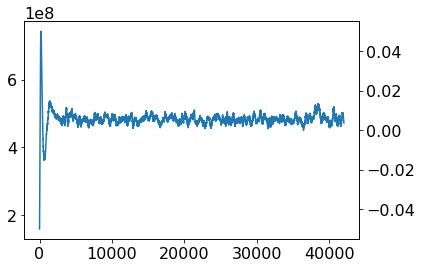

In [68]:
smoothing = True
window_length = 201
polyorder = 1

elbo_loss_history = custom_loss.elbo_loss_history
downsampling_loss_history = custom_loss.downsampling_loss_history

if smoothing:
    if len(custom_loss.elbo_loss_history) > window_length:
        elbo_loss_history = savgol_filter(
            custom_loss.elbo_loss_history,
            window_length=window_length,
            polyorder=polyorder)
    if len(custom_loss.downsampling_loss_history) > window_length:
        downsampling_loss_history = savgol_filter(
            custom_loss.downsampling_loss_history,
            window_length=window_length,
            polyorder=polyorder)

ax = plt.gca()
ax.plot(elbo_loss_history)
ax2 = ax.twinx()
ax2.plot(downsampling_loss_history, color='red')

## Exploration

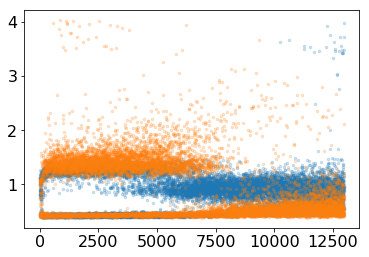

In [83]:
x = fsd_codec.decode(fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")))['mu_hi'] / (
    torch.tensor(sc_fingerprint_datastore.empirical_fsd_mu_hi).float().cuda().unsqueeze(-1))
x = x.detach().cpu().numpy()
plt.plot(x[:, 0], alpha=0.2, lw=0, marker='.', markersize=5)
plt.plot(x[:, 1], alpha=0.2, lw=0, marker='.', markersize=5)
# plt.ylim([0, 5])

mean_e_obs: 177.9057924888606
mean_e_hi (map): 200.49013367281987
mean_e_lo (map): 119.01782304264799
e_hi_z: 21
e_obs_z: 14
mu_e_hi (prior): 211.5821533203125
phi_e_hi (prior): 0.2947547733783722
p_zero_e_hi (prior): 0.0030803163535892963
mean_e_hi (prior): 210.930419921875
phi_e_lo: 0.20000000298023224
mu_lo: tensor([[0.0210]])
phi_lo: tensor([[0.9976]])
w_lo: tensor([[1.]])
mu_hi: tensor([[5.0675, 1.6445]])
phi_hi: tensor([[0.0325, 0.3925]])
w_hi: tensor([[0.5605, 0.4395]])


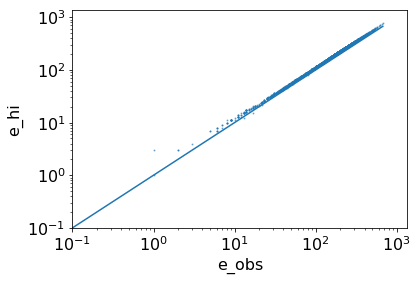

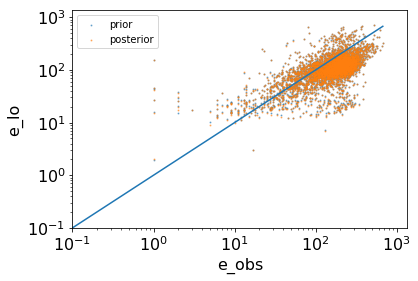

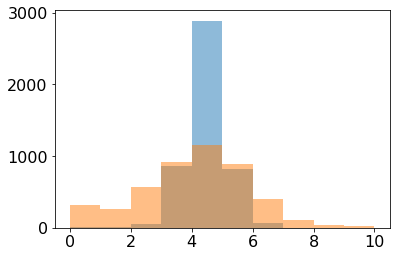

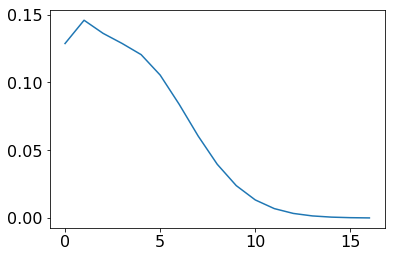

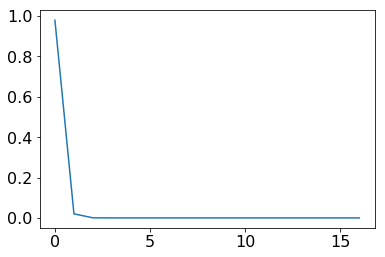

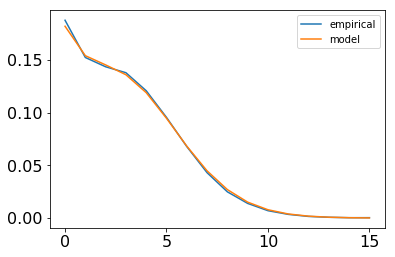

In [86]:
gene_index = 0
cell_shard_size = 200

exploration_e_lo_sum_width = training_e_lo_sum_width
exploration_e_hi_sum_width = training_e_hi_sum_width
exploration_e_lo_log_prob_prefactor = training_e_lo_log_prob_prefactor
exploration_e_hi_log_prob_prefactor = training_e_hi_log_prob_prefactor
exploration_e_obs_log_prob_prefactor = training_e_obs_log_prob_prefactor
exploration_fingerprint_obs_log_prob_prefactor = training_fingerprint_obs_log_prob_prefactor

expr_dict = get_expression_map(
    gene_index, model, sc_fingerprint_datastore,
    e_lo_sum_width=exploration_e_lo_sum_width,
    e_hi_sum_width=exploration_e_hi_sum_width,
    cell_shard_size=cell_shard_size,
    e_lo_log_prob_prefactor=exploration_e_lo_log_prob_prefactor,
    e_hi_log_prob_prefactor=exploration_e_hi_log_prob_prefactor,
    e_obs_log_prob_prefactor=exploration_e_obs_log_prob_prefactor,
    fingerprint_obs_log_prob_prefactor=exploration_fingerprint_obs_log_prob_prefactor)

e_lo, e_hi = expr_dict['e_lo_map'], expr_dict['e_hi_map']

fsd_xi_loc = pyro.param("fsd_xi_posterior_loc")[gene_index, :]
fsd_params_dict = fsd_codec.decode(fsd_xi_loc.unsqueeze(0))
dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)

assert model.e_hi_prior_dist == 'zinb'
e_hi_prior_dist = ZeroInflatedNegativeBinomial(
    logit_zero=pyro.param("logit_p_zero_e_hi"),
    mu=pyro.param("mu_e_hi"),
    phi=pyro.param("phi_e_hi"))


e_obs = np.sum(sc_fingerprint_datastore.fingerprint_array[:, gene_index, :], -1)
mean_e_obs = np.mean(e_obs)
mean_e_hi = np.mean(e_hi)
mean_e_lo = np.mean(e_lo)
e_hi_z = np.sum(e_hi == 0)
e_obs_z = np.sum(e_obs == 0)

print('mean_e_obs:', mean_e_obs)
print('mean_e_hi (map):', mean_e_hi)
print('mean_e_lo (map):', mean_e_lo)
print('e_hi_z:', e_hi_z)
print('e_obs_z:', e_obs_z)
print('mu_e_hi (prior):', pyro.param("mu_e_hi")[gene_index].item())
print('phi_e_hi (prior):', pyro.param("phi_e_hi")[gene_index].item())
print('p_zero_e_hi (prior):', torch.sigmoid(pyro.param("logit_p_zero_e_hi")[gene_index]).item())
print('mean_e_hi (prior):', e_hi_prior_dist.mean[gene_index].item())
print('phi_e_lo:', pyro.param("phi_e_lo")[gene_index].item())



fig = plt.figure()
e_obs = np.sum(sc_fingerprint_datastore.fingerprint_array[:, gene_index, :], -1)
plt.scatter(e_obs, e_hi, s=1, alpha=0.5)
plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
plt.xlabel('e_obs', fontsize=16)
plt.ylabel('e_hi', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1, 2*np.max(e_obs)))
plt.ylim((0.1, 2*np.max(e_obs)))


fig = plt.figure()
plt.scatter(e_obs, expr_dict['mu_e_lo'], alpha=0.5, s=1, label='prior')
plt.scatter(e_obs, e_lo, alpha=0.5, s=1, label='posterior')
plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
plt.xlabel('e_obs', fontsize=16)
plt.ylabel('e_lo', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1, 2*np.max(e_obs)))
plt.ylim((0.1, 2*np.max(e_obs)))
plt.legend()

plt.figure()
_ = plt.hist(e_lo - expr_dict['e_lo_min'], alpha=0.5, range=(0, exploration_e_lo_sum_width), bins=exploration_e_lo_sum_width)
_ = plt.hist(e_hi - expr_dict['e_hi_min'], alpha=0.5, range=(0, exploration_e_hi_sum_width), bins=exploration_e_hi_sum_width)




for k, v in fsd_params_dict.items():
    print(f"{k}: {v.clone().detach().cpu()}")


fig = plt.figure()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_datastore.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_hi)

fig = plt.figure()
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_datastore.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_lo)




empircal_fsd = sc_fingerprint_datastore.fingerprint_array[:, gene_index, :]
empircal_fsd = empircal_fsd / (1e-12 + np.sum(empircal_fsd, -1)[:, None])
empircal_fsd = np.sum(empircal_fsd, 0)
empircal_fsd = empircal_fsd / np.sum(empircal_fsd)

model_fsd = e_obs[:, None] * np.exp(expr_dict['fit_log_prob_map'])
model_fsd = model_fsd / (1e-12 + np.sum(model_fsd, -1)[:, None])
model_fsd = np.sum(model_fsd, 0)
model_fsd = model_fsd / np.sum(model_fsd)

plt.figure()
plt.plot(empircal_fsd, label='empirical')
plt.plot(model_fsd, label='model')
plt.legend()

<ErrorbarContainer object of 3 artists>

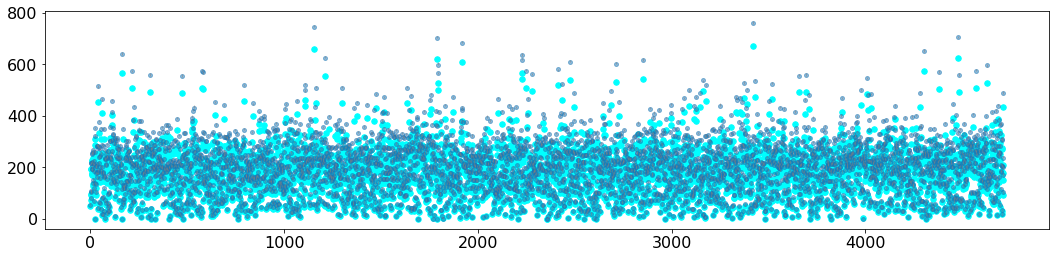

In [87]:
plt.figure(figsize=(18,4))

err = np.vstack((expr_dict['e_hi_map'] - expr_dict['e_hi_ci_lower'], expr_dict['e_hi_ci_upper'] - expr_dict['e_hi_map']))
# err = np.sqrt(expr_dict['e_hi_var'])
plt.scatter(np.arange(0, sc_fingerprint_datastore.n_cells), e_obs, marker='o', color='cyan', s=30)
plt.errorbar(np.arange(0, sc_fingerprint_datastore.n_cells),
             expr_dict['e_hi_map'],
             barsabove=True, elinewidth=1, lw=0,
             marker='.', ecolor='gray', markersize=8,
             yerr=err, alpha=0.5)
# plt.scatter(np.arange(0, sc_fingerprint_datastore.n_cells), expr_dict['e_hi_mean'], marker='x', color='red', s=8)


Text(0.5, 0, '$e_\\mathrm{obs}$')

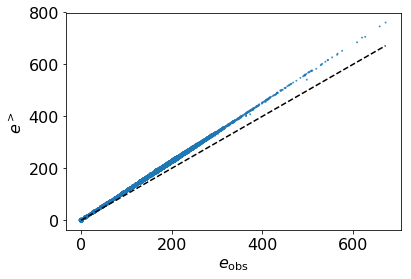

In [88]:
from collections import Counter
x_vals = e_obs
y_vals = expr_dict['e_hi_map']
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)
weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x_vals, y_vals, s=weights, alpha=0.7)
plt.plot([0, np.max(x_vals)], [0, np.max(x_vals)], '--', color='black')
plt.ylabel(r'$e^>$', fontsize=16)
plt.xlabel(r'$e_\mathrm{obs}$', fontsize=16)

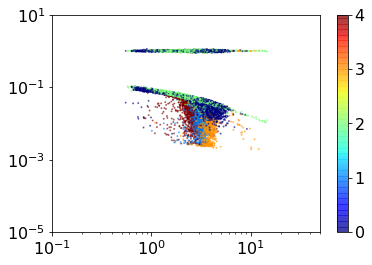

In [89]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)
    mu_lo = dist_lo.mean.cpu().numpy()
    mu_hi = dist_hi.mean.cpu().numpy()
    phi_lo = fsd_params_dict['phi_lo'].squeeze(-1).cpu().numpy()
    
assignments = torch.argmin(
    (fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")).unsqueeze(-1)
     - fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs")).permute(-1, -2)).pow(2).sum(1), dim=-1).detach().cpu().numpy()

plt.scatter(mu_hi.squeeze(), mu_lo.squeeze() / mu_hi.squeeze(), s=1, alpha=0.5, c=assignments, cmap=plt.cm.jet)
plt.scatter(mu_hi.squeeze(), phi_lo.squeeze(), s=1, alpha=0.5, c=assignments, cmap=plt.cm.jet)
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-5, 10.))
plt.xlim((0.1, 50)) 
plt.colorbar()

In [90]:
print(np.where(assignments == 4))

(array([   4,    5,   10, ..., 8466, 8762, 8766]),)


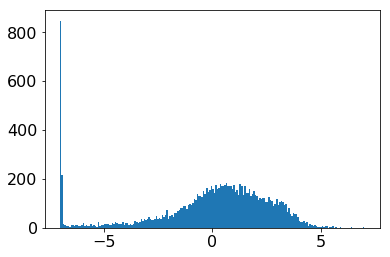

In [91]:
logit_p_zero_e_hi = pyro.param("logit_p_zero_e_hi").detach().cpu().numpy()
_ = plt.hist(logit_p_zero_e_hi, bins=200)

## Save model

In [92]:
model_output_path = os.path.join(output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
pyro.get_param_store().save(model_output_path)

## Extract and save the droplet-count matrix

In [97]:
from pyro_extras import ZeroInflatedNegativeBinomial

log_frequency = 5
max_cells_per_e_lo_e_hi = 500_000
max_adaptive_extraction_e_lo_sum_width = 100
max_adaptive_extraction_e_hi_sum_width = 100

extraction_e_lo_sum_width = training_e_lo_sum_width
extraction_e_hi_sum_width = training_e_hi_sum_width
extraction_e_lo_log_prob_prefactor = training_e_lo_log_prob_prefactor
extraction_e_hi_log_prob_prefactor = training_e_hi_log_prob_prefactor
extraction_e_obs_log_prob_prefactor = training_e_obs_log_prob_prefactor
extraction_fingerprint_obs_log_prob_prefactor = training_fingerprint_obs_log_prob_prefactor

# calculate some auxiliary quantities for adaptive determination of marginalization widths
assert model.e_hi_prior_dist == 'zinb'
e_hi_prior_dist = ZeroInflatedNegativeBinomial(
    logit_zero=pyro.param("logit_p_zero_e_hi"),
    mu=pyro.param("mu_e_hi"),
    phi=pyro.param("phi_e_hi"))
e_hi_std = e_hi_prior_dist.variance.sqrt().clone().detach().cpu().numpy()
e_hi_mean = e_hi_prior_dist.mean.clone().detach().cpu().numpy()

fsd_dist_lo, fsd_dist_hi = fsd_codec.get_fsd_components(fsd_codec.decode(pyro.param("fsd_xi_posterior_loc")), None)
fsd_mu_hi = fsd_dist_hi.mean.clone().detach().cpu().numpy().squeeze()
e_hi_mu = pyro.param("mu_e_hi").clone().detach().cpu().numpy()
e_lo_std = (pyro.param("alpha_c").item() + pyro.param("beta_c").item()) * (
    e_hi_mean * fsd_mu_hi / model.median_fsd_mu_hi)

In [98]:
e_lo_map = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.int)
e_lo_mean = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.float32)
e_lo_var = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.float32)
e_lo_ci_lower = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.int)
e_lo_ci_upper = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.int)

e_hi_map = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.int)
e_hi_mean = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.float32)
e_hi_var = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.float32)
e_hi_ci_lower = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.int)
e_hi_ci_upper = np.zeros((sc_fingerprint_datastore.n_cells, sc_fingerprint_datastore.n_genes), dtype=np.int)

t0 = time.time()

for i_gene in range(sc_fingerprint_datastore.n_genes):
    adaptive_extraction_e_lo_sum_width = min(
        max_adaptive_extraction_e_lo_sum_width,
        extraction_e_lo_sum_width + int(np.ceil(2 * e_lo_std[i_gene])))
    adaptive_extraction_e_hi_sum_width = min(
        max_adaptive_extraction_e_hi_sum_width,
        extraction_e_hi_sum_width + int(np.ceil(2 * e_hi_std[i_gene])))
    adaptive_cell_shard_size = min(
        sc_fingerprint_datastore.n_cells,
        max(1, int(np.ceil(max_cells_per_e_lo_e_hi / (
            adaptive_extraction_e_lo_sum_width * adaptive_extraction_e_hi_sum_width)))))
    
    expr_dict = get_expression_map(
        i_gene, model, sc_fingerprint_datastore,
        e_lo_sum_width=adaptive_extraction_e_lo_sum_width,
        e_hi_sum_width=adaptive_extraction_e_hi_sum_width,
        cell_shard_size=adaptive_cell_shard_size,
        e_lo_log_prob_prefactor=extraction_e_lo_log_prob_prefactor,
        e_hi_log_prob_prefactor=extraction_e_hi_log_prob_prefactor,
        e_obs_log_prob_prefactor=extraction_e_obs_log_prob_prefactor,
        fingerprint_obs_log_prob_prefactor=extraction_fingerprint_obs_log_prob_prefactor)
    
    e_lo_map[:, i_gene] = expr_dict['e_lo_map']
    e_lo_mean[:, i_gene] = expr_dict['e_lo_mean']
    e_lo_var[:, i_gene] = expr_dict['e_lo_var']
    e_lo_ci_lower[:, i_gene] = expr_dict['e_lo_ci_lower']
    e_lo_ci_upper[:, i_gene] = expr_dict['e_lo_ci_upper']

    e_hi_map[:, i_gene] = expr_dict['e_hi_map']
    e_hi_mean[:, i_gene] = expr_dict['e_hi_mean']
    e_hi_var[:, i_gene] = expr_dict['e_hi_var']
    e_hi_ci_lower[:, i_gene] = expr_dict['e_hi_ci_lower']
    e_hi_ci_upper[:, i_gene] = expr_dict['e_hi_ci_upper']
    
    if i_gene % log_frequency == 0 and i_gene > 0:
        t1 = time.time()
        seconds_per_gene = (t1 - t0) / log_frequency
        t0 = t1
        logging.warning(f'Processing gene {i_gene+1}/{sc_fingerprint_datastore.n_genes} ({seconds_per_gene:.2f} s/gene)...')

# gene indices and cell barcodes
original_gene_indices = np.asarray(list(map(
    sc_fingerprint_datastore.internal_gene_index_to_original_gene_index_map.get,
    range(sc_fingerprint_datastore.n_genes))))
cell_barcodes = np.asarray(sc_fingerprint.barcode_list)

# save
np.save(e_lo_map_output_path, e_lo_map)
np.save(e_lo_mean_output_path, e_lo_mean)
np.save(e_lo_var_output_path, e_lo_var)
np.save(e_lo_ci_lower_output_path, e_lo_ci_lower)
np.save(e_lo_ci_upper_output_path, e_lo_ci_upper)

np.save(e_hi_map_output_path, e_hi_map)
np.save(e_hi_mean_output_path, e_hi_mean)
np.save(e_hi_var_output_path, e_hi_var)
np.save(e_hi_ci_lower_output_path, e_hi_ci_lower)
np.save(e_hi_ci_upper_output_path, e_hi_ci_upper)
np.save(gene_indices_output_path, original_gene_indices)
np.save(cell_barcodes_output_path, cell_barcodes)

## Visualizing the distributions parameters $\xi$

In [93]:
import pyro.distributions as dist
from pyro_extras import MixtureDistribution

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")).detach().cpu().numpy()

    n_prior_samples = 100_000
    fsd_xi_prior_locs = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs"))
    fsd_xi_prior_scales = pyro.param("fsd_xi_prior_scales")
    
    if model.fsd_gmm_num_components > 1:
        fsd_xi_prior_log_weights = pyro.param("fsd_xi_prior_weights_map").log()
        fsd_xi_prior_log_weights_tuple = tuple(
            fsd_xi_prior_log_weights[j]
            for j in range(model.fsd_gmm_num_components))        
        fsd_xi_prior_components_tuple = tuple(
            dist.Normal(fsd_xi_prior_locs[j, :], fsd_xi_prior_scales[j, :]).to_event(1)
            for j in range(model.fsd_gmm_num_components))
        fsd_xi_prior_dist = MixtureDistribution(
            fsd_xi_prior_log_weights_tuple, fsd_xi_prior_components_tuple)
    else:
            fsd_xi_prior_dist = dist.Normal(fsd_xi_prior_locs[0, :], fsd_xi_prior_scales[0, :]).to_event(1)


    xi_prior = fsd_xi_prior_dist.sample((n_prior_samples,)).cpu().numpy()

In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xi_prior_pca_fit = pca.fit(xi_prior)
xi_prior_pca = xi_prior_pca_fit.transform(xi_prior)
xi_posterior_pca = xi_prior_pca_fit.transform(xi_posterior)
xi_prior_locs_pca = xi_prior_pca_fit.transform(pyro.param("fsd_xi_prior_locs").detach().cpu().numpy())

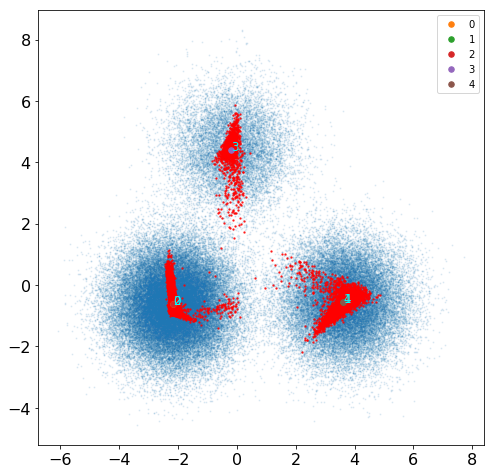

In [95]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(xi_prior_pca[:, 0], xi_prior_pca[:, 1], alpha=0.1, s=1)
plt.scatter(xi_posterior_pca[:, 0], xi_posterior_pca[:, 1], alpha=0.7, s=2, color='red')
for j in range(model.fsd_gmm_num_components):
    plt.scatter(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], s=30, marker='o', label=str(j))
    plt.text(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], str(j), color='cyan', size=12)
plt.legend()

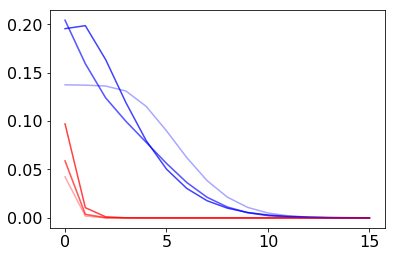

In [96]:
fig = plt.figure()

for fsd_gmm_comp_idx in range(5):
    fsd_xi = pyro.param("fsd_xi_prior_locs")[fsd_gmm_comp_idx, :]
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_codec.decode(fsd_xi), None)
    max_fs = sc_fingerprint_datastore.max_family_size + 1

    p_hi = dist_hi.log_prob(torch.arange(1, max_fs).float().cuda()).detach().cpu().exp().numpy().flatten()
    p_lo = dist_lo.log_prob(torch.arange(1, max_fs).float().cuda()).detach().cpu().exp().numpy().flatten()
    plt.plot(p_hi, color='blue', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map")[fsd_gmm_comp_idx].item()))
    plt.plot(p_lo, color='red', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map")[fsd_gmm_comp_idx].item()))

In [ ]:
pyro.param("fsd_xi_prior_locs")[2]

In [ ]:
fsd_codec.decode(pyro.param("fsd_xi_prior_locs")[3])

In [ ]:
fsd_codec.decode(pyro.param("fsd_xi_prior_locs")[7])

In [ ]:
fsd_codec.decode(pyro.param("fsd_xi_prior_locs")[8])

## UMAP visualization

In [ ]:
import umap

def get_non_doublet_indices(counts_matrix):
    return list(map(operator.itemgetter(0),
             sorted(enumerate(np.sum(counts_matrix, -1)),
                    key=operator.itemgetter(1), reverse=True)))[(counts_matrix.shape[0] // 10):]

In [ ]:
umap_trans = umap.UMAP(min_dist=0.1, metric='correlation', n_neighbors=30, random_state=1984)
top_k_genes = 3000

In [ ]:
# normalized droplet counts
normalized_droplet_count = droplet_counts[:, :top_k_genes] / np.sum(droplet_counts[:, :top_k_genes], -1)[:, None]

# normalized obs (raw) counts
obs_counts = np.sum(sc_fingerprint_datastore.fingerprint_array, -1)
normalized_obs_count = obs_counts[:, :top_k_genes] / np.sum(obs_counts[:, :top_k_genes], -1)[:, None]

In [ ]:
kept_indices = get_non_doublet_indices(obs_counts)
obs_counts_embedding = umap_trans.fit_transform(normalized_obs_count[kept_indices, :])
plt.scatter(obs_counts_embedding[:, 0], obs_counts_embedding[:, 1], s=1, alpha=0.1)

In [ ]:
kept_indices = get_non_doublet_indices(droplet_counts)
droplet_counts_embedding = umap_trans.fit_transform(normalized_droplet_count[kept_indices, :])

In [ ]:
plt.scatter(droplet_counts_embedding[:, 0], droplet_counts_embedding[:, 1], s=1, alpha=0.1)

In [ ]:
#
# demonstration that log det of sorting operation = 0, even with stickbreaking parameters
#
# fsd_codec = GeneralNegativeBinomialMixtureFamilySizeDistributionCodec(
#     sc_fingerprint_datastore=sc_fingerprint_datastore,
#     n_fsd_lo_comps=3,
#     n_fsd_hi_comps=4,
#     fsd_init_params_dict=fsd_init_params_dict)

# xi = torch.nn.Parameter(torch.randn(fsd_codec.total_fsd_params, device=fsd_codec.device), requires_grad=True)
# xi_sorted = fsd_codec.get_sorted_fsd_xi(xi)
# grads = []
# for j in range(len(xi)):
#     xi_sorted[j].backward(retain_graph=True)
#     grads.append(xi.grad.clone())
#     _ = xi.grad.data.zero_()

# torch.det(torch.stack(grads))